# ===========================
# MAIN - all network sizes collected 
# Benchmarking 3D PORTRAITS - U P S C A L I N G 
# ===========================

##### Blog regarding choosing plot type depending on data to communicate
+ https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/

In [1]:
# import
from multidimvis_main import *

In [2]:
# add functions to multidimvis_main 

def embed_umap_2D(Matrix, n_neigh, spre, m_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_comp = 2 

    U = umap.UMAP(
        n_neighbors = n_neigh,
        spread = spre,
        min_dist = m_dist,
        n_components = n_comp,
        metric = metric, 
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed


def exec_time(start, end):
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 3)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))
   
    return m,s


def embed_umap_3D(Matrix, n_neighbors, spread, min_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix (UMAP).
    Return dict (keys: node IDs, values: x,y,z).
    '''

    n_components = 3 # for 3D

    U_3d = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric,
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    embed = U_3d.fit_transform(Matrix)
    
    return embed

# CUBE

-------
## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)
------

In [ ]:
# 3D CUBE 

organism = 'grid'

G_grid = nx.grid_graph([10,10,10],periodic=False)
G = G_grid 

In [ ]:
# prepare for 3D running of cube
# + aufteilen in scripten wie bei tree

In [ ]:
# plus same for torus 

# TORUS

In [ ]:
itr = 50 

d_netsize_branch1 = {1093:3, 5461:4} #9841:3,19531:5,597871:9,1398101:4,5592404:4,12093235:6}

d_walltime_spring1 = {}
d_corr_spring1 = {}
d_layoutdicts_spring1 = {}
d_graphedges_spring1 = {}

d_walltime_layout1 = {}
d_corr_layout1 = {}
d_layoutdicts_layout1 = {}
d_graphedges_layout1 = {}

for i,branch in d_netsize_branch1.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring1[i] = list(G.edges())
    d_graphedges_layout1[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring1[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring1[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout1[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout1[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring1[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout1[i] = corr_layout
    
    print('--- next graph ---')

In [ ]:
# 1-5k
# netsize: corr.
d_corr_layout1 = 
d_corr_spring1 = 

# netsize: seconds
d_walltime_spring1 = 
d_walltime_layout1 = 

In [ ]:
itr = 50 

d_netsize_branch2 = {9841:3,19531:5} #597871:9,1398101:4,5592404:4,12093235:6}

d_walltime_spring2 = {}
d_corr_spring2 = {}
d_layoutdicts_spring2 = {}
d_graphedges_spring2 = {}

d_walltime_layout2 = {}
d_corr_layout2 = {}
d_layoutdicts_layout2 = {}
d_graphedges_layout2 = {}

for i,branch in d_netsize_branch2.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring2[i] = list(G.edges())
    d_graphedges_layout2[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring2[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring2[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout2[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout2[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring2[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout2[i] = corr_layout
    
    print('--- next graph ---')

In [ ]:
#10k-20k
# netsize: corr.
d_corr_layout2 = 
d_corr_spring2 = 

# netsize: seconds
d_walltime_spring2 = 
d_walltime_layout2 = 

In [ ]:
#50k-100k
# netsize: corr.
d_corr_layout3 = 
d_corr_spring3 = 

# netsize: seconds
d_walltime_spring3 = 
d_walltime_layout3 = 

In [ ]:
#500k
# netsize: corr.
d_corr_layout4 = 
d_corr_spring4 = 

# netsize: seconds
d_walltime_spring4 = 
d_walltime_layout4 = 

In [ ]:
itr = 50 

d_netsize_branch4 = {1398101:4} #,5592404:4,12093235:6}

d_walltime_spring4 = {}
d_corr_spring4 = {}
d_layoutdicts_spring4 = {}
d_graphedges_spring4 = {}

d_walltime_layout4 = {}
d_corr_layout4 = {}
d_layoutdicts_layout4 = {}
d_graphedges_layout4 = {}

for i,branch in d_netsize_branch4.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring4[i] = list(G.edges())
    d_graphedges_layout4[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring4[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring4[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout4[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout4[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring4[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout4[i] = corr_layout
    
    print('--- next graph ---')

In [ ]:
#1Mio
# netsize: corr.
d_corr_layout5 = 
d_corr_spring5 = 

# netsize: seconds
d_walltime_spring5 = 
d_walltime_layout5 = 

In [ ]:
itr = 50 

d_netsize_branch5 = {5592404:4} #,12093235:6}

d_walltime_spring5 = {}
d_corr_spring5 = {}
d_layoutdicts_spring5 = {}
d_graphedges_spring5 = {}

d_walltime_layout5 = {}
d_corr_layout5 = {}
d_layoutdicts_layout5 = {}
d_graphedges_layout5 = {}

for i,branch in d_netsize_branch5.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring5[i] = list(G.edges())
    d_graphedges_layout5[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring5[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring5[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout5[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout5[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring5[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout5[i] = corr_layout
    
    print('--- next graph ---')

In [ ]:
#5Mio
# netsize: corr.
d_corr_layout6 = 
d_corr_spring6 = 

# netsize: seconds
d_walltime_spring6 = 
d_walltime_layout6 = 

In [ ]:
itr = 50 

d_netsize_branch6 = {12093235:6}

d_walltime_spring6 = {}
d_corr_spring6 = {}
d_layoutdicts_spring6 = {}
d_graphedges_spring6 = {}

d_walltime_layout6 = {}
d_corr_layout6 = {}
d_layoutdicts_layout6 = {}
d_graphedges_layout6 = {}

for i,branch in d_netsize_branch6.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring6[i] = list(G.edges())
    d_graphedges_layout6[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring6[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring6[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout6[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout6[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring6[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout6[i] = corr_layout
    
    print('--- next graph ---')

In [ ]:
#10Mio
# netsize: corr.
d_corr_layout7 = 
d_corr_spring7 = 

# netsize: seconds
d_walltime_spring7 = 
d_walltime_layout7 = 

In [ ]:
itr = 50 

d_netsize_branch3 = {597871:9} #,1398101:4,5592404:4,12093235:6}

d_walltime_spring3 = {}
d_corr_spring3 = {}
d_layoutdicts_spring3 = {}
d_graphedges_spring3 = {}

d_walltime_layout3 = {}
d_corr_layout3 = {}
d_layoutdicts_layout3 = {}
d_graphedges_layout3 = {}

for i,branch in d_netsize_branch3.items():
    
    G = nx.full_rary_tree(branch,i)
    d_graphedges_spring3[i] = list(G.edges())
    d_graphedges_layout3[i] = list(G.edges())

    #-----------------------------
    
    print('--- Spring ---')
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = itr, dim = 2)

    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

    end = time.time()

    #===========================
    # SPRING save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_spring3[i] = posG_spring2D_norm

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # SPRING save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_spring3[i] = walltime

    #-----------------------------
    
    print('--- RWR ---')

    start = time.time()
    r = .9 
    alpha = 1.0

    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    DM_rwr = pd.DataFrame(FM_m_array)

    n_neighbors = 20
    spread = 1.0
    min_dist = 0.01
    metric = 'cosine'
    lnr = 1 
    nep = None 

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    
    #===========================
    # RWR save layout as dict + append to dict { netsize : {nodeid:xyz,nodeid:xyz,...}, netsize : {nodeid:xyz, nodeid:xyz,...}}
    #===========================
    d_layoutdicts_layout3[i] = posG_complete_umap_rwr_norm 

    print('# Nodes (netsize):', i)
    m,s = exec_time(start,end)

    #===========================
    # RWR save WALLTIME for layout in dict : { netsize : walltime }
    #===========================
    walltime = s+m*60
    d_walltime_layout3[i] = walltime
    
    #===========================
    # get and save corr.fact. to dict : { netsize : corr.fact. }
    #===========================
    print('--- calculate SPL ---')
    spl = nx.all_pairs_shortest_path_length(G)
    DM_spl_2D = pd.DataFrame(dict(spl))
    print('--- SPL done ---')

    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    dist_network2D = {}
    for p1, p2 in it.combinations(DM_spl_2D.index,2):
        dist_network2D[p1,p2] = DM_spl_2D[p1][p2]    
    
    dist_layout2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap_rwr_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    y_layout = list(dist_layout2D.values())
    x_layout = list(dist_network2D.values())
   
    print('--- calculate correlation factors ---')

    gradient_spring, intercept_spring, corr_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_corr_spring3[i] = corr_spring
    
    gradient_layout, intercept_layout, corr_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
    d_corr_layout3[i] = corr_layout
    
    print('--- next graph ---')

--- Spring ---


In [ ]:
d_walltime_layout_all = {**d_walltime_layout1, **d_walltime_layout2, **d_walltime_layout3, **d_walltime_layout4, **d_walltime_layout5, **d_walltime_layout6, **d_walltime_layout7}
d_corr_layout_all = {**d_corr_layout1, **d_corr_layout2, **d_corr_layout3, **d_corr_layout4, **d_corr_layout5, **d_corr_layout6, **d_corr_layout7}
d_layoutdicts_layout_all = {**d_layoutdicts_layout1, **d_layoutdicts_layout2, **d_layoutdicts_layout3, **d_layoutdicts_layout4, **d_layoutdicts_layout5, **d_layoutdicts_layout6, **d_layoutdicts_layout7}
d_graphedges_layout_all = {**d_graphedges_layout1, **d_graphedges_layout2, **d_graphedges_layout3, **d_graphedges_layout4, **d_graphedges_layout5, **d_graphedges_layout6, **d_graphedges_layout7}

In [ ]:
d_walltime_spring_all = {**d_walltime_spring1, **d_walltime_spring2, **d_walltime_spring3, **d_walltime_spring4, **d_walltime_spring5, **d_walltime_spring6, **d_walltime_spring7}
d_corr_spring_all = {**d_corr_spring1, **d_corr_spring2, **d_corr_spring3, **d_corr_spring4, **d_corr_spring5, **d_corr_spring6, **d_corr_spring7}
d_layoutdicts_spring_all = {**d_layoutdicts_spring1, **d_layoutdicts_spring2, **d_layoutdicts_spring3, **d_layoutdicts_spring4, **d_layoutdicts_spring5, **d_layoutdicts_spring6, **d_layoutdicts_spring7}
d_graphedges_spring_all = {**d_graphedges_spring1, **d_graphedges_spring2, **d_graphedges_spring3, **d_graphedges_spring4, **d_graphedges_spring5, **d_graphedges_spring6, **d_graphedges_spring7}

In [ ]:
d_netsize_branch_all = {**d_netsize_branch1, **d_netsize_branch2, *+d_netsize_branch3, **d_netsize_branch4, **d_netsize_branch5, **d_netsize_branch6, **d_netsize_branch7}

In [ ]:
# Network size vs. Correlation Factor 

labelsize= 14

x_spring = list(d_netsize_branch_all.keys())
y_spring = list(d_corr_spring_all.values())
x_layout = list(d_netsize_branch_all.keys())
y_layout = list(d_corr_layout_all.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Network Size [# Nodes]", fontsize=labelsize)
plt.ylabel("corr.coeff.", fontsize=labelsize)

plt.plot(x_spring,y_spring, '-', c = 'cornflowerblue', alpha = 0.3)
plt.scatter(x_spring,y_spring, c = 'cornflowerblue', s = 30, alpha = 1.0)
plt.plot(x_layout,y_layout, '-', c = 'orange', alpha = 0.3)
plt.scatter(x_layout,y_layout, c = 'orange', s = 30, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Network Size vs. Corr. Factor'+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/upscale_CorrNetdist_'+feature+'_'+organism+'.png')

In [ ]:
# Network size vs. Time

labelsize= 14

x_spring = list(d_netsize_branch_all.keys())
y_spring = list(d_walltime_spring_all.values())
x_layout = list(d_netsize_branch_all.keys())
y_layout = list(d_walltime_layout_all.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Network Size [# Nodes]", fontsize=labelsize)
plt.ylabel("Time [s]", fontsize=labelsize)

plt.plot(x_spring,y_spring, '-', c = 'cornflowerblue', alpha = 0.3)
plt.scatter(x_spring,y_spring, c = 'cornflowerblue', s = 30, alpha = 1.0)
plt.plot(x_layout,y_layout, '-', c = 'orange', alpha = 0.3)
plt.scatter(x_layout,y_layout, c = 'orange', s = 30, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Network Size vs. Corr. Factor'+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/upscale_TimeNetdist_'+feature+'_'+organism+'.png')

In [ ]:
# recreate Graph from edges : 

edges_first = list(d_graphedges_spring.values())[0]
G_first = nx.Graph(edges_first)

______________
# 3D BENCHMARK - visual + statistical 
______________

# CHOOSE NETWORK

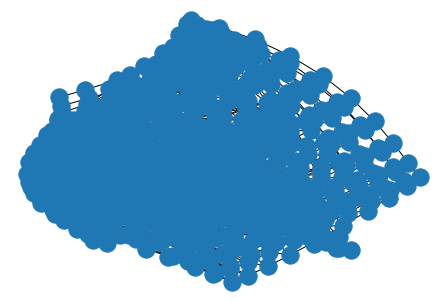

In [229]:
# 3D CUBE 

organism = 'grid'

G_grid = nx.grid_graph([10,10,10],periodic=False)
G = G_grid 

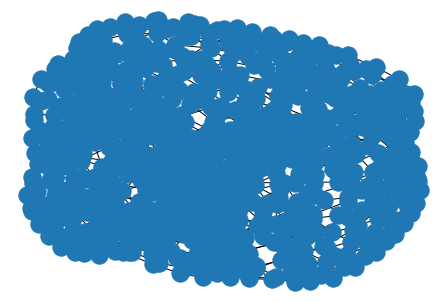

In [224]:
# TORUS 

organism = 'torus'

G_tor = nx.grid_2d_graph(44,22,periodic=True)
G = G_tor

+ PREDEFINED FEATURE MATRIX

In [230]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


# CENTRALITY 

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

#round(DM_cent,2)

In [233]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = 'black'

# Node sizes 

#scalef= 0.2
#size = list(draw_node_degree(G, scalef).values())

#scalef= 0.05
#size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'RdYlBu')
colours = list(d_colours.values())

labelsize = 18
legendfontsize = 12

___________
## NETWORK DISTANCE 
___________

In [181]:
%%time 

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = round(nx.shortest_path_length(G,geneA,geneB),1)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl_3D = pd.DataFrame(Mspl, columns = list(G.nodes()), index=list(G.nodes()))

df_spl_3D = DM_spl_3D
x = df_spl_3D.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
DM_spl_norm_3D = pd.DataFrame(x_scaled)

CPU times: user 3min 41s, sys: 2.19 s, total: 3min 43s
Wall time: 3min 44s


In [182]:
dist_network3D = {}
for p1, p2 in it.combinations(DM_spl_3D.index,2):
    dist_network3D[p1,p2] = DM_spl_3D[p1][p2]

## SPRING

In [131]:
%%time 

posG_spring3D = nx.spring_layout(G, iterations = 150, dim = 3)

df_posG = pd.DataFrame(posG_spring3D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

spring_nodes = get_trace_nodes_3D(posG_spring3D_norm, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D_norm, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: grid
CPU times: user 14 s, sys: 246 ms, total: 14.3 s
Wall time: 15.3 s


'output_plots/3Dtoynetwork_spring_grid.html'

## 3D PORTRAITS 

+ ADJACENCIES

In [217]:
%%time 
n_neighbors = 8 #deg_mean # balance between local and global structure in the data
spread = 1.0
min_dist = 0.8 #defines how dense points are stacked together 
metric ='cosine'

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
 
umap_3D_adj = embed_umap_3D(DM_adj, n_neighbors, spread, min_dist, metric)

posG_3Dumap_adj = get_posG_3D(list(G.nodes()), umap_3D_adj)
posG_3D_complete_umap_adj = {key:posG_3Dumap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_adj_nodes = get_trace_nodes_3D(posG_3D_complete_umap_adj_norm, None, 'grey',#colours, 
                                    4, opac = 0.8) # size3d)
umap_adj_edges = get_trace_edges_3D(G, posG_3D_complete_umap_adj_norm, 'lightgrey',# edge_colordark, 
                                    1.0) 

umap_adj_data = [umap_adj_edges, umap_adj_nodes]

fig = pgo.Figure()
for i in umap_adj_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/benchmark/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 4.62 s, sys: 169 ms, total: 4.79 s
Wall time: 5.14 s


'output_plots/3Dtoynetwork_umap_ADJ_torus.html'

+ RANDOM WALK - visiting probability

In [983]:
degree = dict(G.degree())
l_degree = list(degree.values())
degree_mean = int(np.mean(l_degree))
degree_max = int(max(l_degree))

In [196]:
##############################
# G R I D 
##############################

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20 #degree_max #degree_mean #20
spread = 1
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = None


##############################
# T O R U S  
##############################

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
#n_neighbors = 10
#spread = 1
#min_dist = 0.1
#metric = 'cosine'
#lnr = 1
#nep = None


In [235]:
%%time 

feature = 'RWRvis'

r = .9
alpha = 1.0

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
DM_rwr = FM_m

umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric)

posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_rwr_nodes = get_trace_nodes_3D(posG_3D_complete_umap_rwr_norm, None, 
                                    #'grey',
                                    colours, 
                                    4, opac = 0.8) # size3d)
umap_rwr_edges = get_trace_edges_3D(G, posG_3D_complete_umap_rwr_norm, edge_colordark, 1.0) 

umap_rwr_data = [umap_rwr_edges, umap_rwr_nodes]

fig = pgo.Figure()
for i in umap_rwr_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/benchmark/3Dtoynetwork_umap_'+feature+'_'+organism+'_.html', auto_open=True)

CPU times: user 14.4 s, sys: 265 ms, total: 14.7 s
Wall time: 14.6 s


'output_plots/3Dtoynetwork_umap_RWRvis_grid_.html'

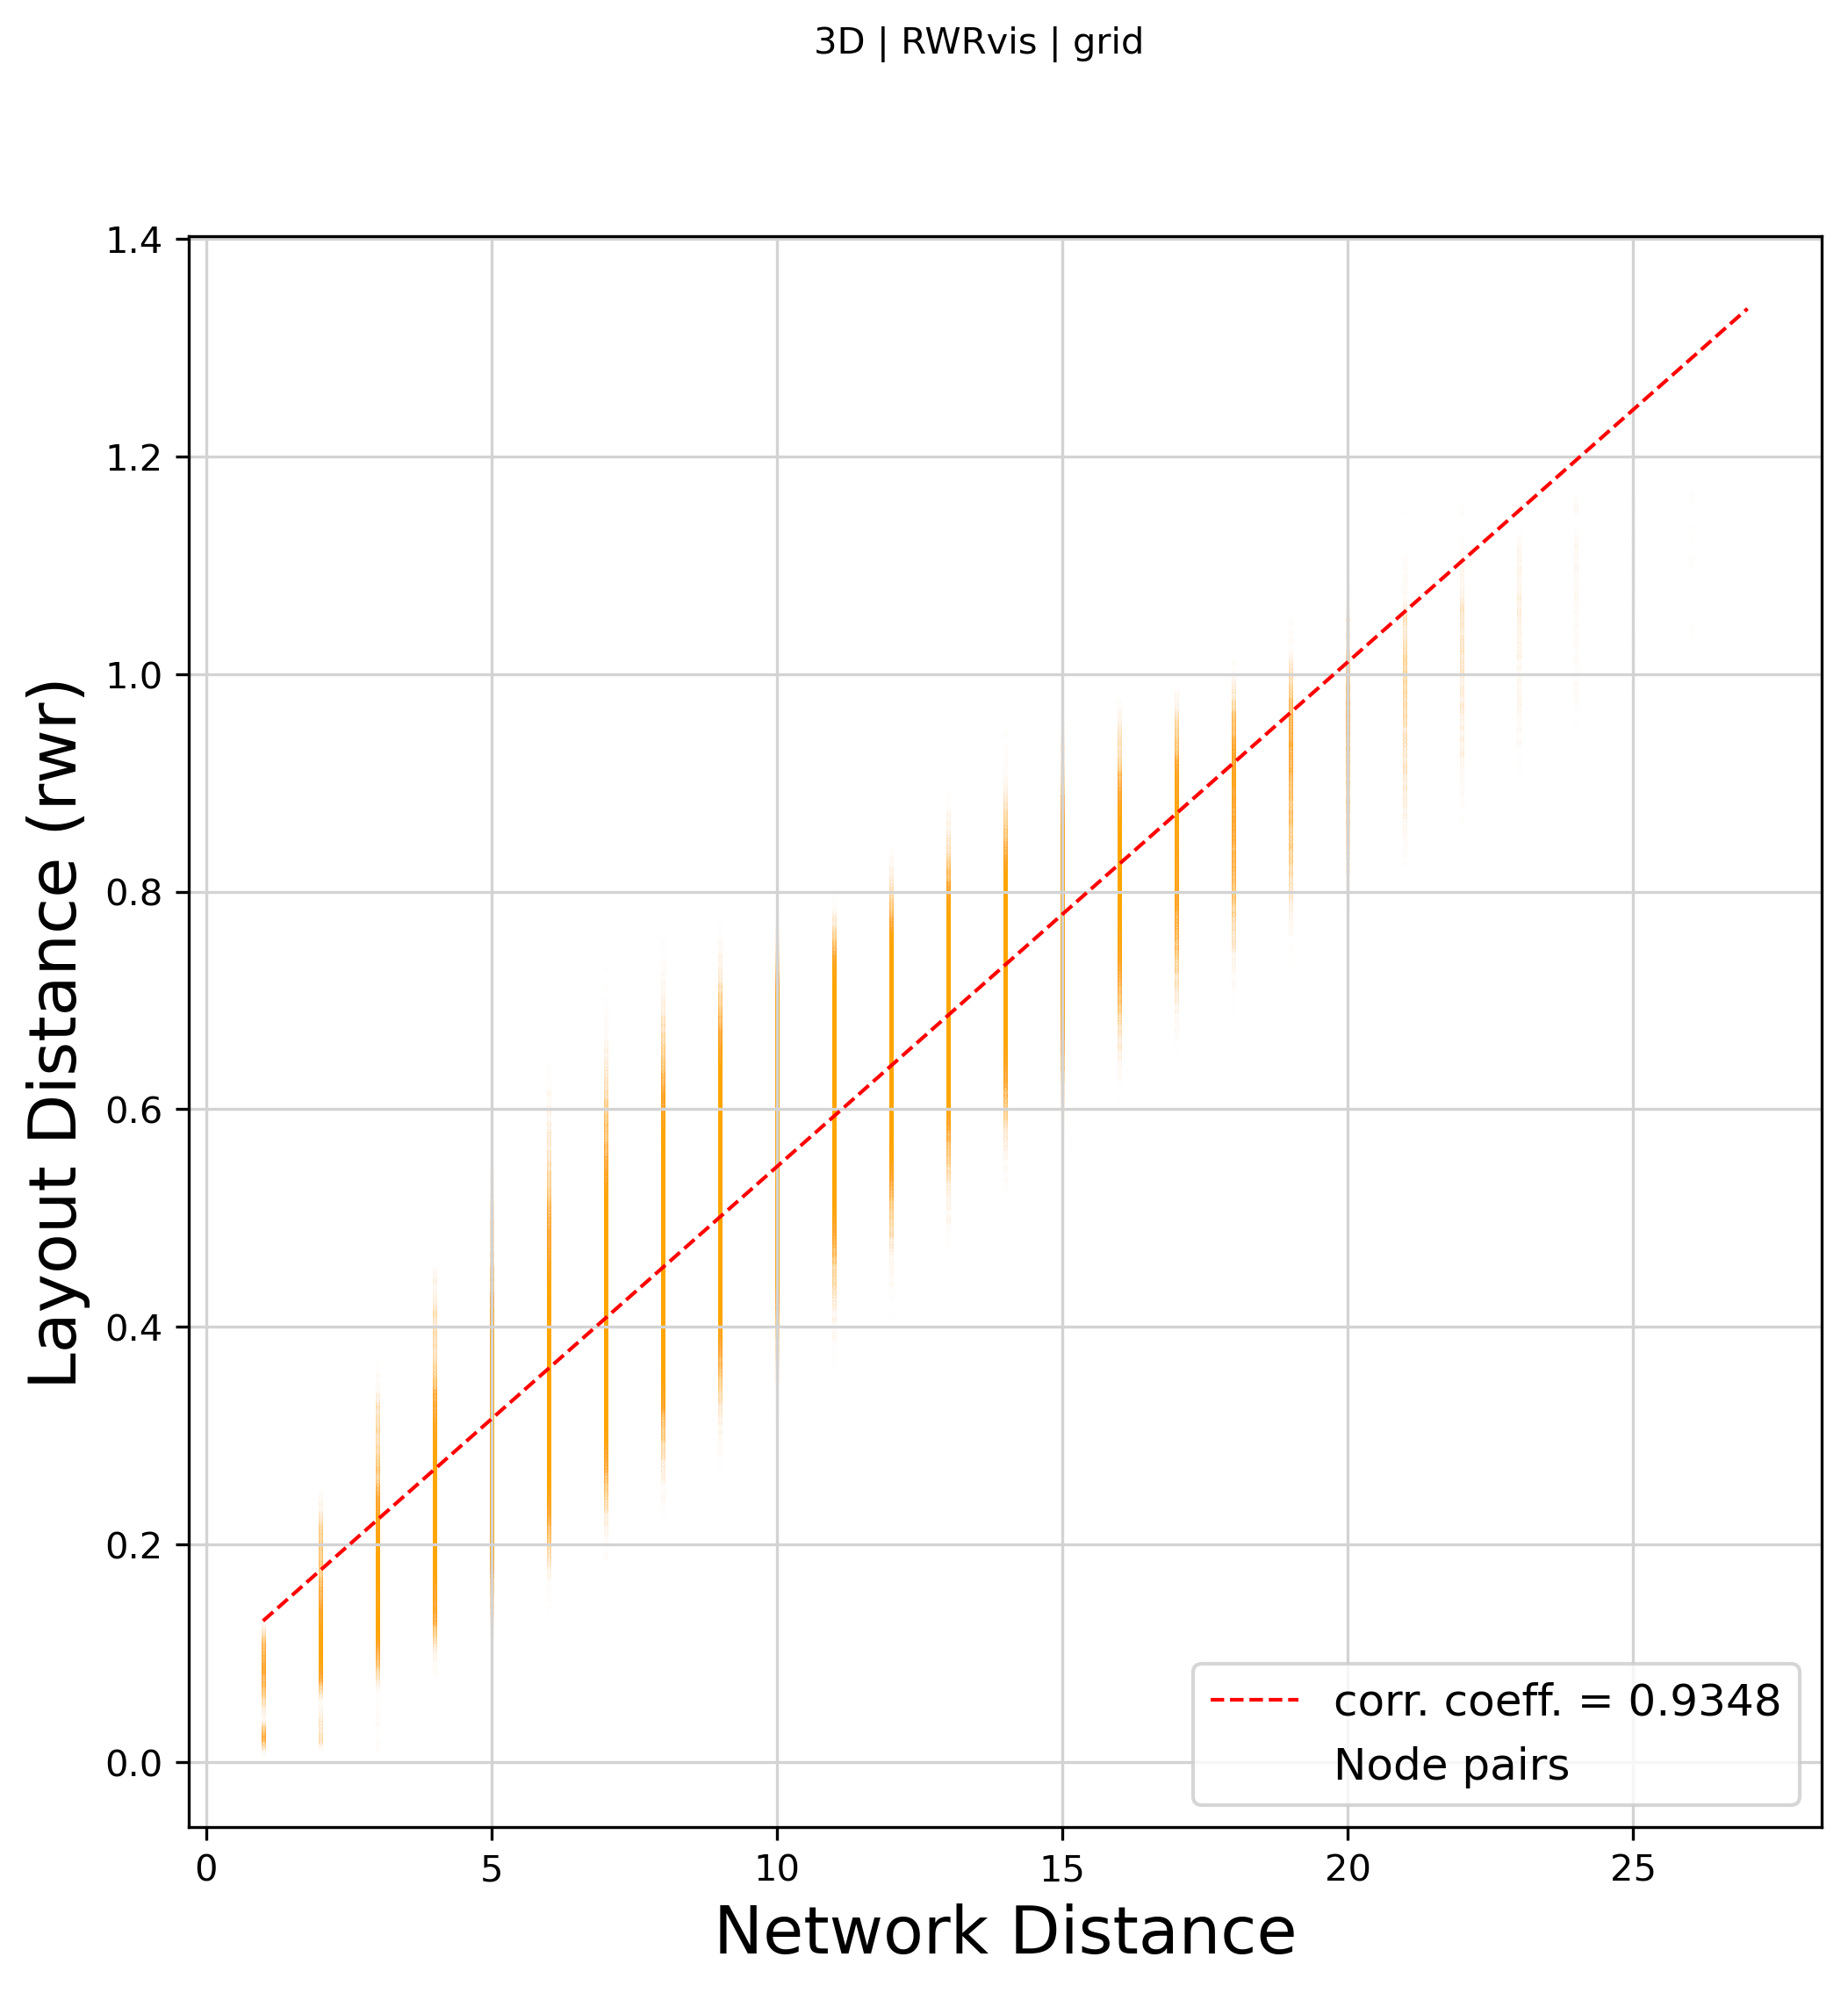

In [234]:
feature = 'RWRvis'

posG_3D_complete_umap = posG_3D_complete_umap_rwr_norm 

# LAYOUT DISTANCE 
dist_layout3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout3D = list(dist_layout3D.values())
x_layout3D = list(dist_network3D.values())
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_layout3D,y_layout3D)
mn_layout3D=min(x_layout3D)
mx_layout3D=max(x_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.legend(('corr. coeff. = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.grid(True, c='lightgrey')

plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/benchmark/3Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')

## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

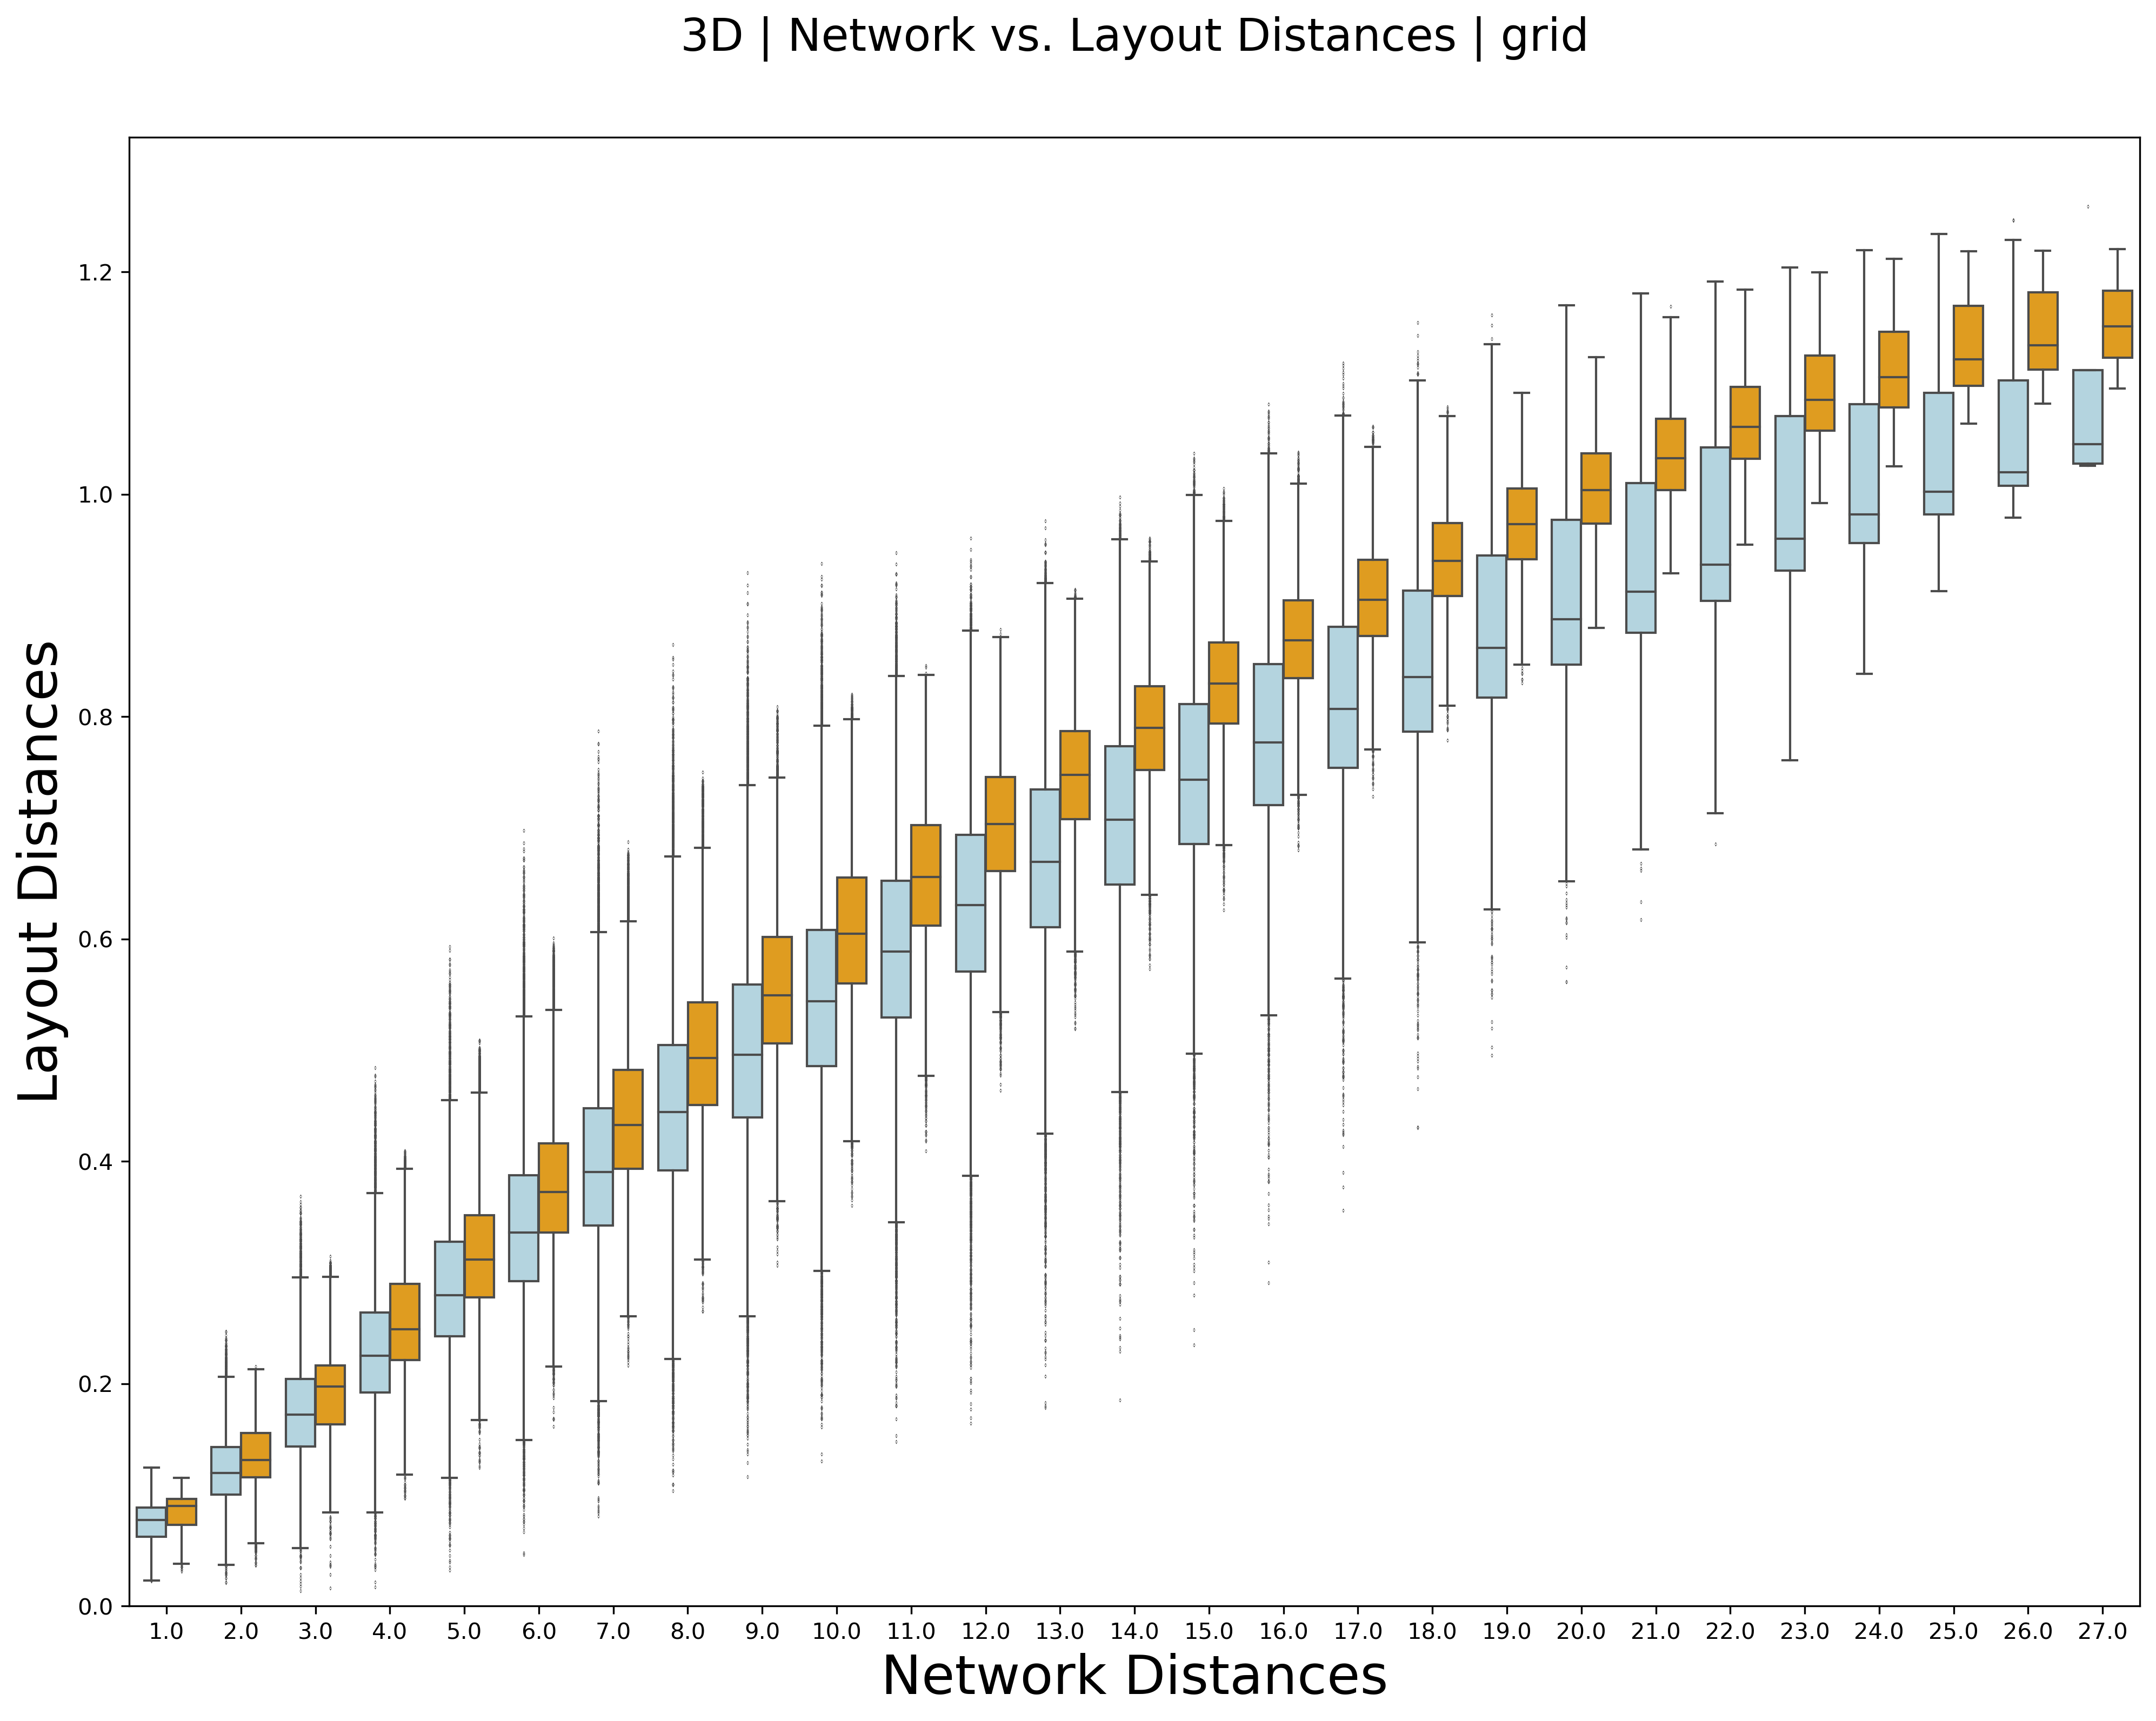

In [979]:
# SPRING DISTANCE
posG_spring3D = nx.spring_layout(G, iterations = 150, dim = 3)
df_posG = pd.DataFrame(posG_spring3D).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
                          
dist_spring3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_spring3D_norm.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

    
# LAYOUT DISTANCE
dist_layout3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    
df_boxplot_ = pd.DataFrame()
df_boxplot_['Spring Layout Distances'] = dist_spring3D.values()
df_boxplot_['Global Layout Distances'] = dist_layout3D.values()
df_boxplot_melt = pd.melt(df_boxplot_)
df_boxplot_melt.columns = ['variable','Layout Distances']

fig = plt.figure(figsize =(16,12), #(20,10), 
                 dpi=300)

pal = {"Spring Layout Distances": "lightblue", "Global Layout Distances": "orange"}
boxplot = sns.boxplot(data=df_boxplot_melt, x=2*(list(dist_network3D.values())), y='Layout Distances', hue='variable', palette = pal,  fliersize = 0.001, notch=False, linewidth=1.0)
    
boxplot.set_xlabel("Network Distances", fontsize=24)
boxplot.set_ylabel("Layout Distances", fontsize=24)
boxplot.set_title('3D | Network vs. Layout Distances | '+organism,  y=1.05,  fontsize=20)

boxplot.get_legend().set_visible(False)

plt.ylim(ymin=0)

#plt.legend(bbox_to_anchor=(1, 0), loc=4, borderaxespad=0.5, fontsize=12);
plt.savefig('output_plots/benchmark/BoxplotDistances3D_spring_rwr_'+organism+'.png')

plt.show()

+ CENTRALITIES

In [227]:
%%time 

n_neighbors = 6 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'

umap_cent_3D = embed_umap_3D(DM_cent, n_neighbors, spread, min_dist, metric)

posG_3Dumap_cent = get_posG_3D(list(G.nodes()), umap_cent_3D)
posG_3D_complete_umap_cent = {key:posG_3Dumap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_cent_nodes = get_trace_nodes_3D(posG_3D_complete_umap_cent_norm, None, colours, 4, opac = 0.8) # size3d)
umap_cent_edges = get_trace_edges_3D(G, posG_3D_complete_umap_cent_norm, edge_colordark, 1.0) 

umap_cent_data = [umap_cent_edges, umap_cent_nodes]

fig = pgo.Figure()
for i in umap_cent_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/benchmark/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 6.1 s, sys: 193 ms, total: 6.29 s
Wall time: 6.63 s


'output_plots/3Dtoynetwork_umap_CENT_torus.html'

_________

# EVALUATION - 3D

# PARAMETER TESTING for high Correlation Coefficients 

### SPRING 

In [820]:
feature = 'spring'

iterationslist = [10,50,100,500,1000,2000,3000,4000,5000]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring3D = nx.spring_layout(G, iterations = i, dim = 3)
    
    df_posG = pd.DataFrame(posG_spring3D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_spring3D_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_spring = list(dist_spring3D.values())
    x_spring = list(dist_network3D.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:00
min: 0 sec: 0
----------------
Spring iter: 50
Execution Time: 00:00:04
min: 0 sec: 4
----------------
Spring iter: 100
Execution Time: 00:00:09
min: 0 sec: 9
----------------
Spring iter: 500
Execution Time: 00:00:43
min: 0 sec: 43
----------------
Spring iter: 1000
Execution Time: 00:01:24
min: 1 sec: 24
----------------
Spring iter: 2000
Execution Time: 00:02:41
min: 2 sec: 41
----------------
Spring iter: 3000
Execution Time: 00:04:25
min: 4 sec: 25
----------------
Spring iter: 4000
Execution Time: 00:05:18
min: 5 sec: 18
----------------
Spring iter: 5000
Execution Time: 00:06:52
min: 6 sec: 52
----------------


In [821]:
d_r_values

{10: 0.18799976355499937,
 50: 0.7246270445246908,
 100: 0.777515522282335,
 500: 0.9521117610503588,
 1000: 0.9515778253042992,
 2000: 0.9470095483457178,
 3000: 0.9532479032585914,
 4000: 0.9489792286462736,
 5000: 0.946038089266481}

In [822]:
d_walltimes

{10: 0,
 50: 4,
 100: 9,
 500: 43,
 1000: 84,
 2000: 161,
 3000: 265,
 4000: 318,
 5000: 412}

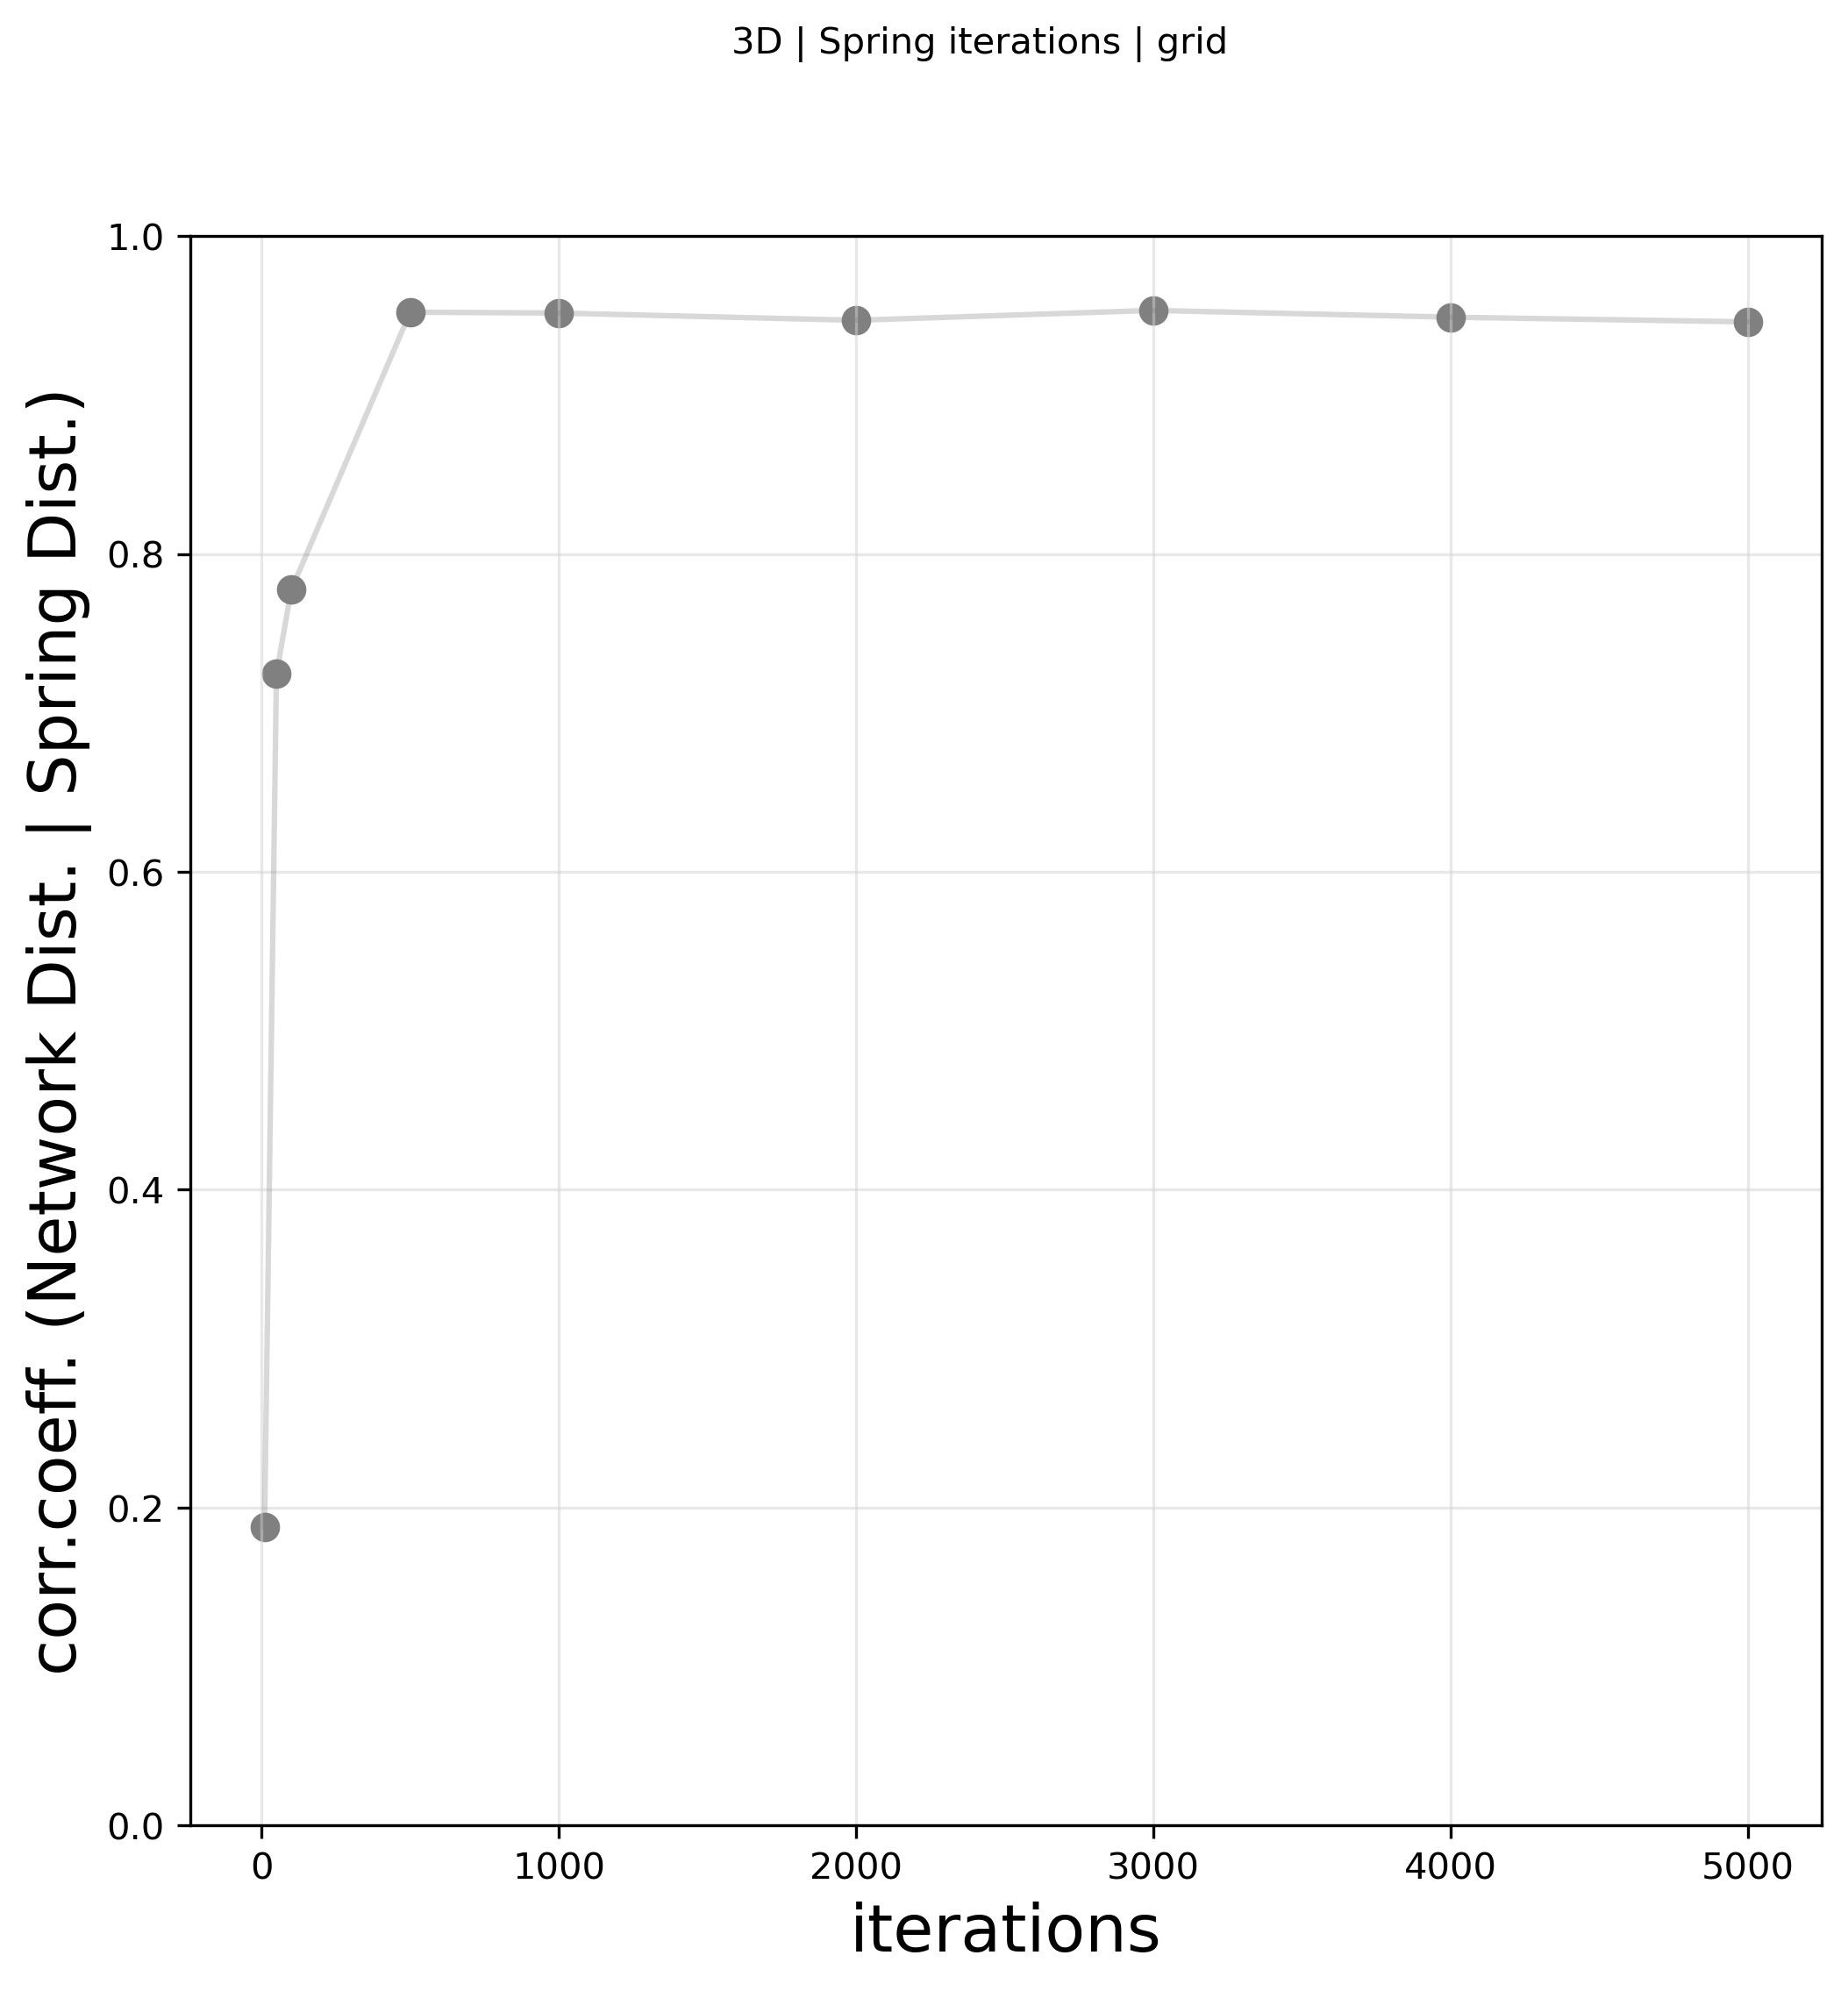

In [823]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0 ,ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_'+feature+'_'+organism+'.png')

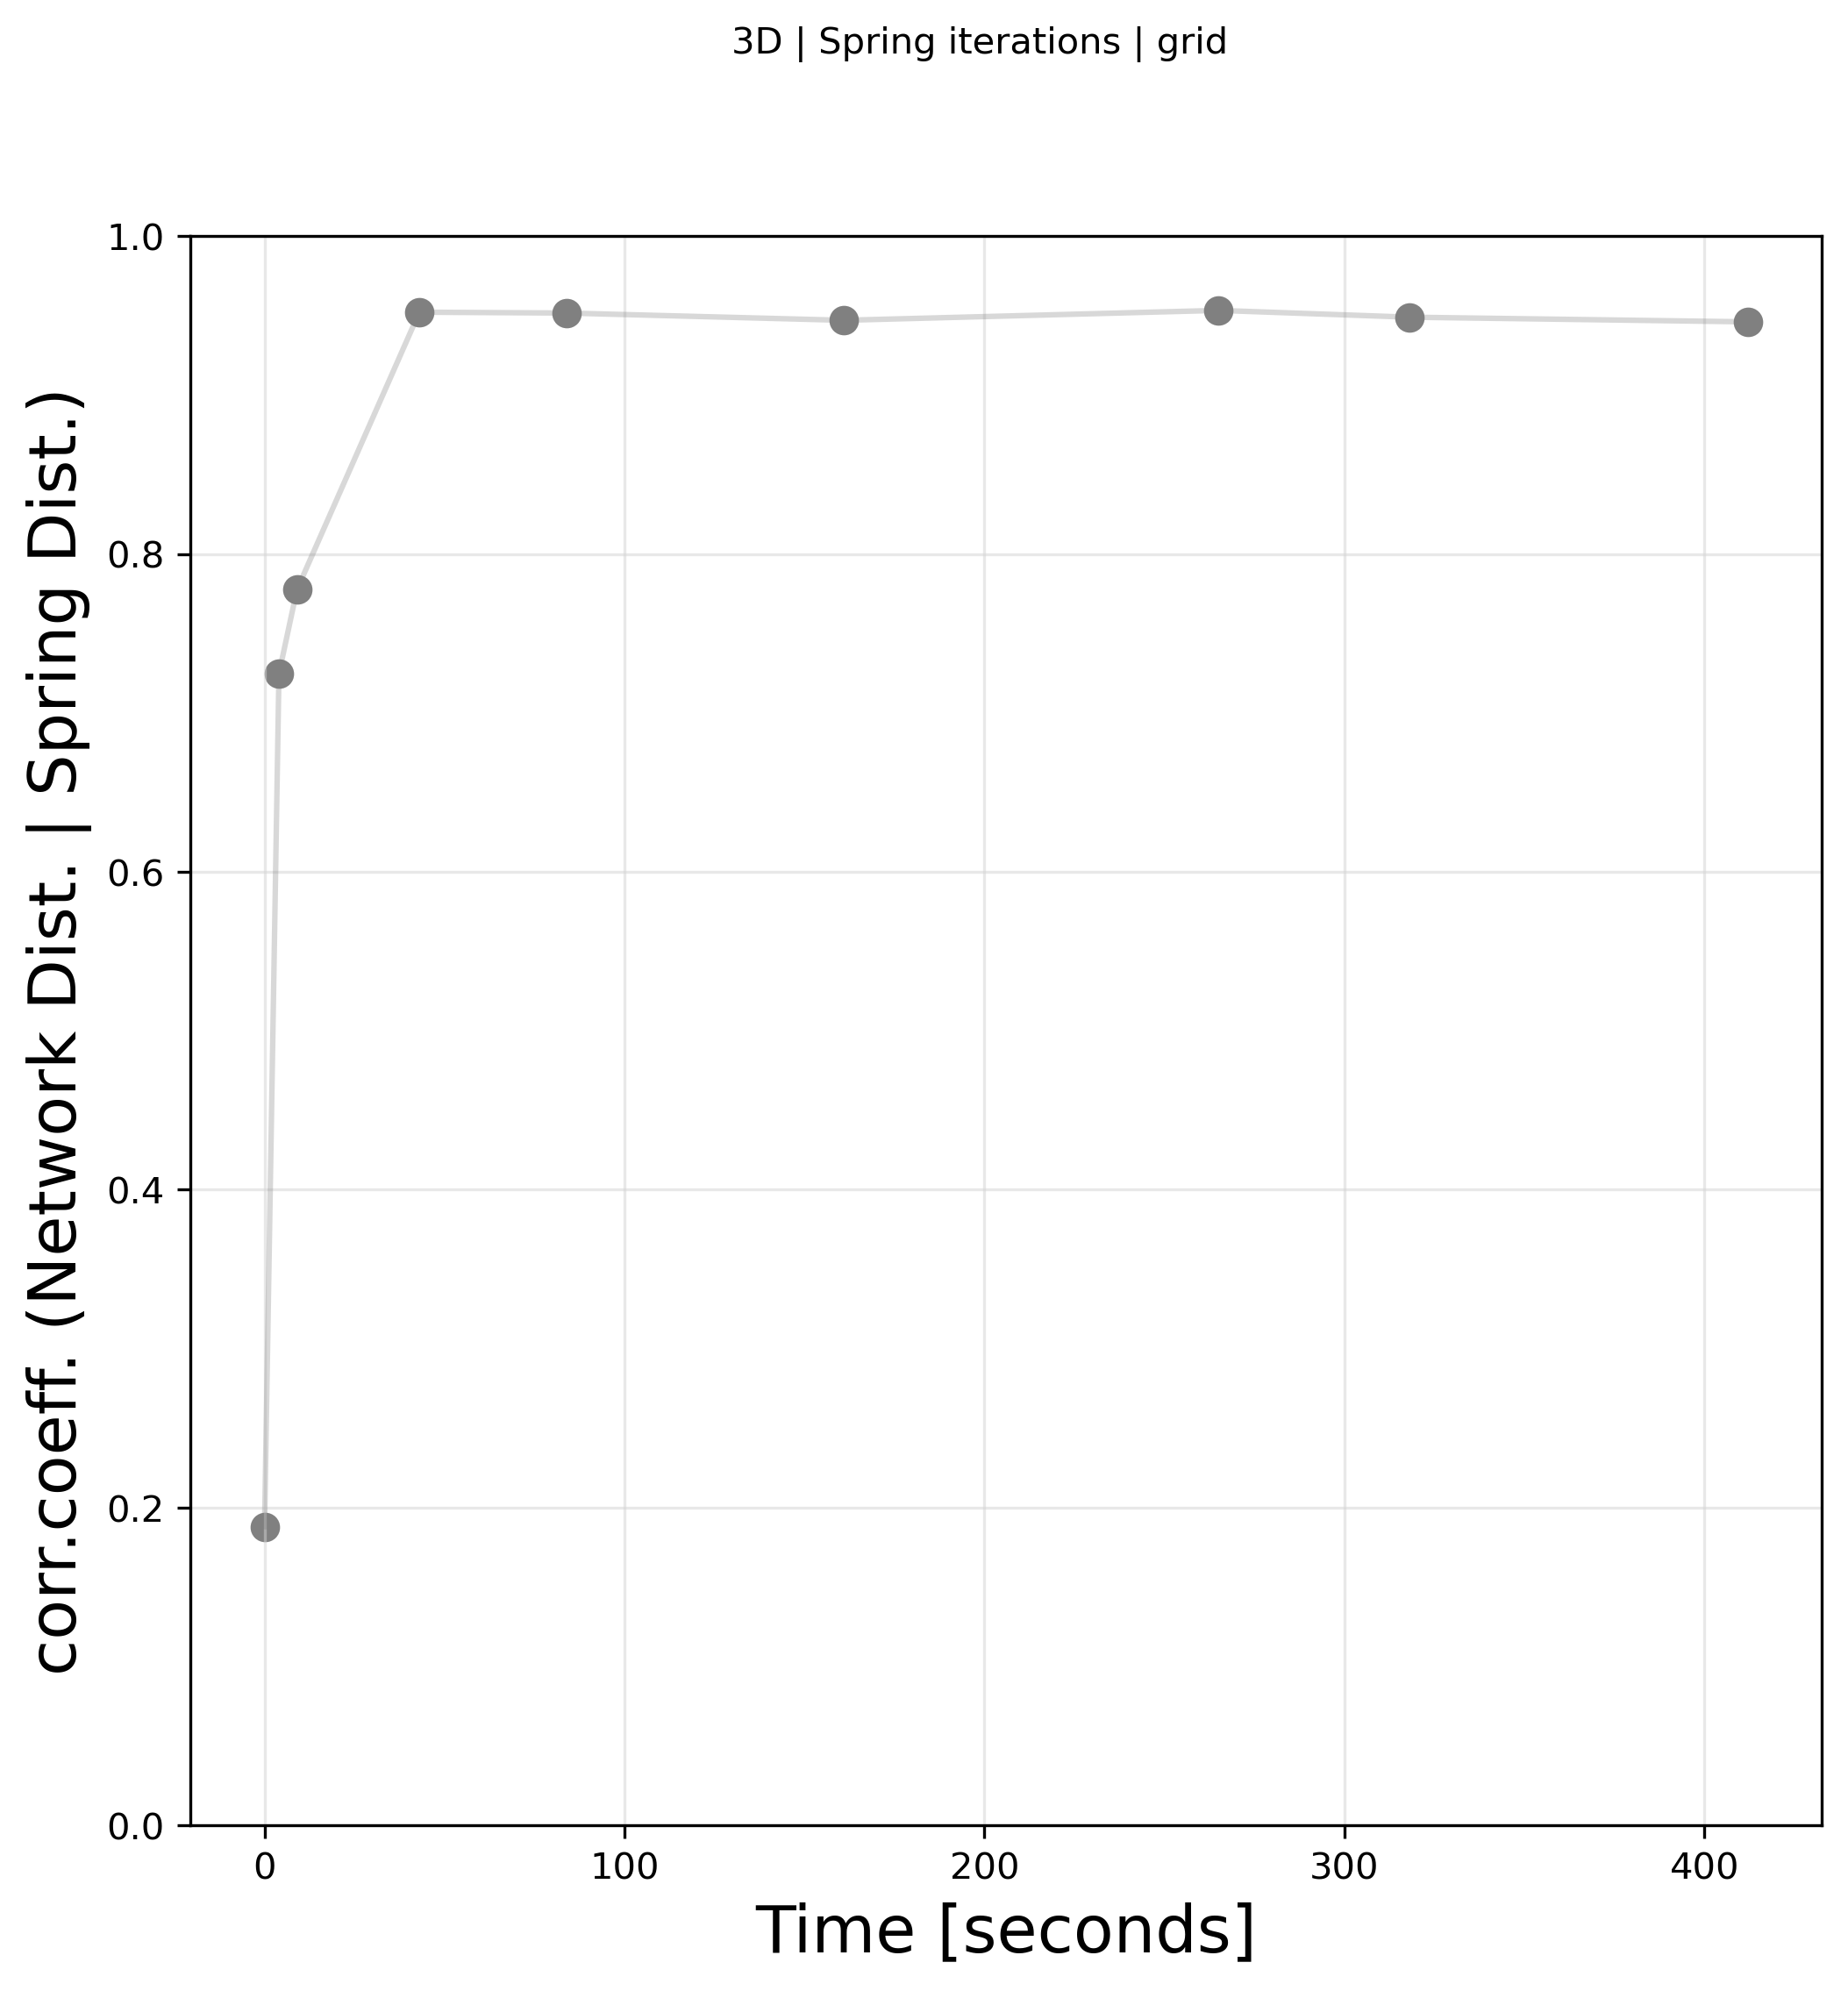

In [824]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_Time_'+feature+'_'+organism+'.png')

### UMAP - RWR

### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [825]:
feature = 'RWRvis'

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20 
spread = 1
min_dist = 0.0
metric ='cosine'
lnr = 0
nep = None

#### ------ NUMBER OF NEIGHBORS ------
+ The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
+ Larger values result in more global views of the manifold, while smaller values result in more local data being preserved 
+ In general values should be in the range 2 to 100.

In [826]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [2,4,8,10,20,50,100,200,400]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, i, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_neigh[i] = r_value_rwr

UMAP n_neighs: 2
Execution Time: 00:00:11
min: 0 sec: 11
UMAP n_neighs: 4
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_neighs: 8
Execution Time: 00:00:11
min: 0 sec: 11
UMAP n_neighs: 10
Execution Time: 00:00:11
min: 0 sec: 11
UMAP n_neighs: 20
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_neighs: 50
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_neighs: 100
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_neighs: 200
Execution Time: 00:00:14
min: 0 sec: 14
UMAP n_neighs: 400
Execution Time: 00:00:14
min: 0 sec: 14


In [827]:
d_rwr_neigh

{2: 11, 4: 12, 8: 11, 10: 11, 20: 13, 50: 12, 100: 13, 200: 14, 400: 14}

In [828]:
d_r_values_rwr_neigh

{2: 0.625051614262009,
 4: 0.7749812278672152,
 8: 0.9300355735048558,
 10: 0.9227326160457113,
 20: 0.9258171412890415,
 50: 0.9028753098889631,
 100: 0.8805329109301595,
 200: 0.8627906565795072,
 400: 0.8792370532499071}

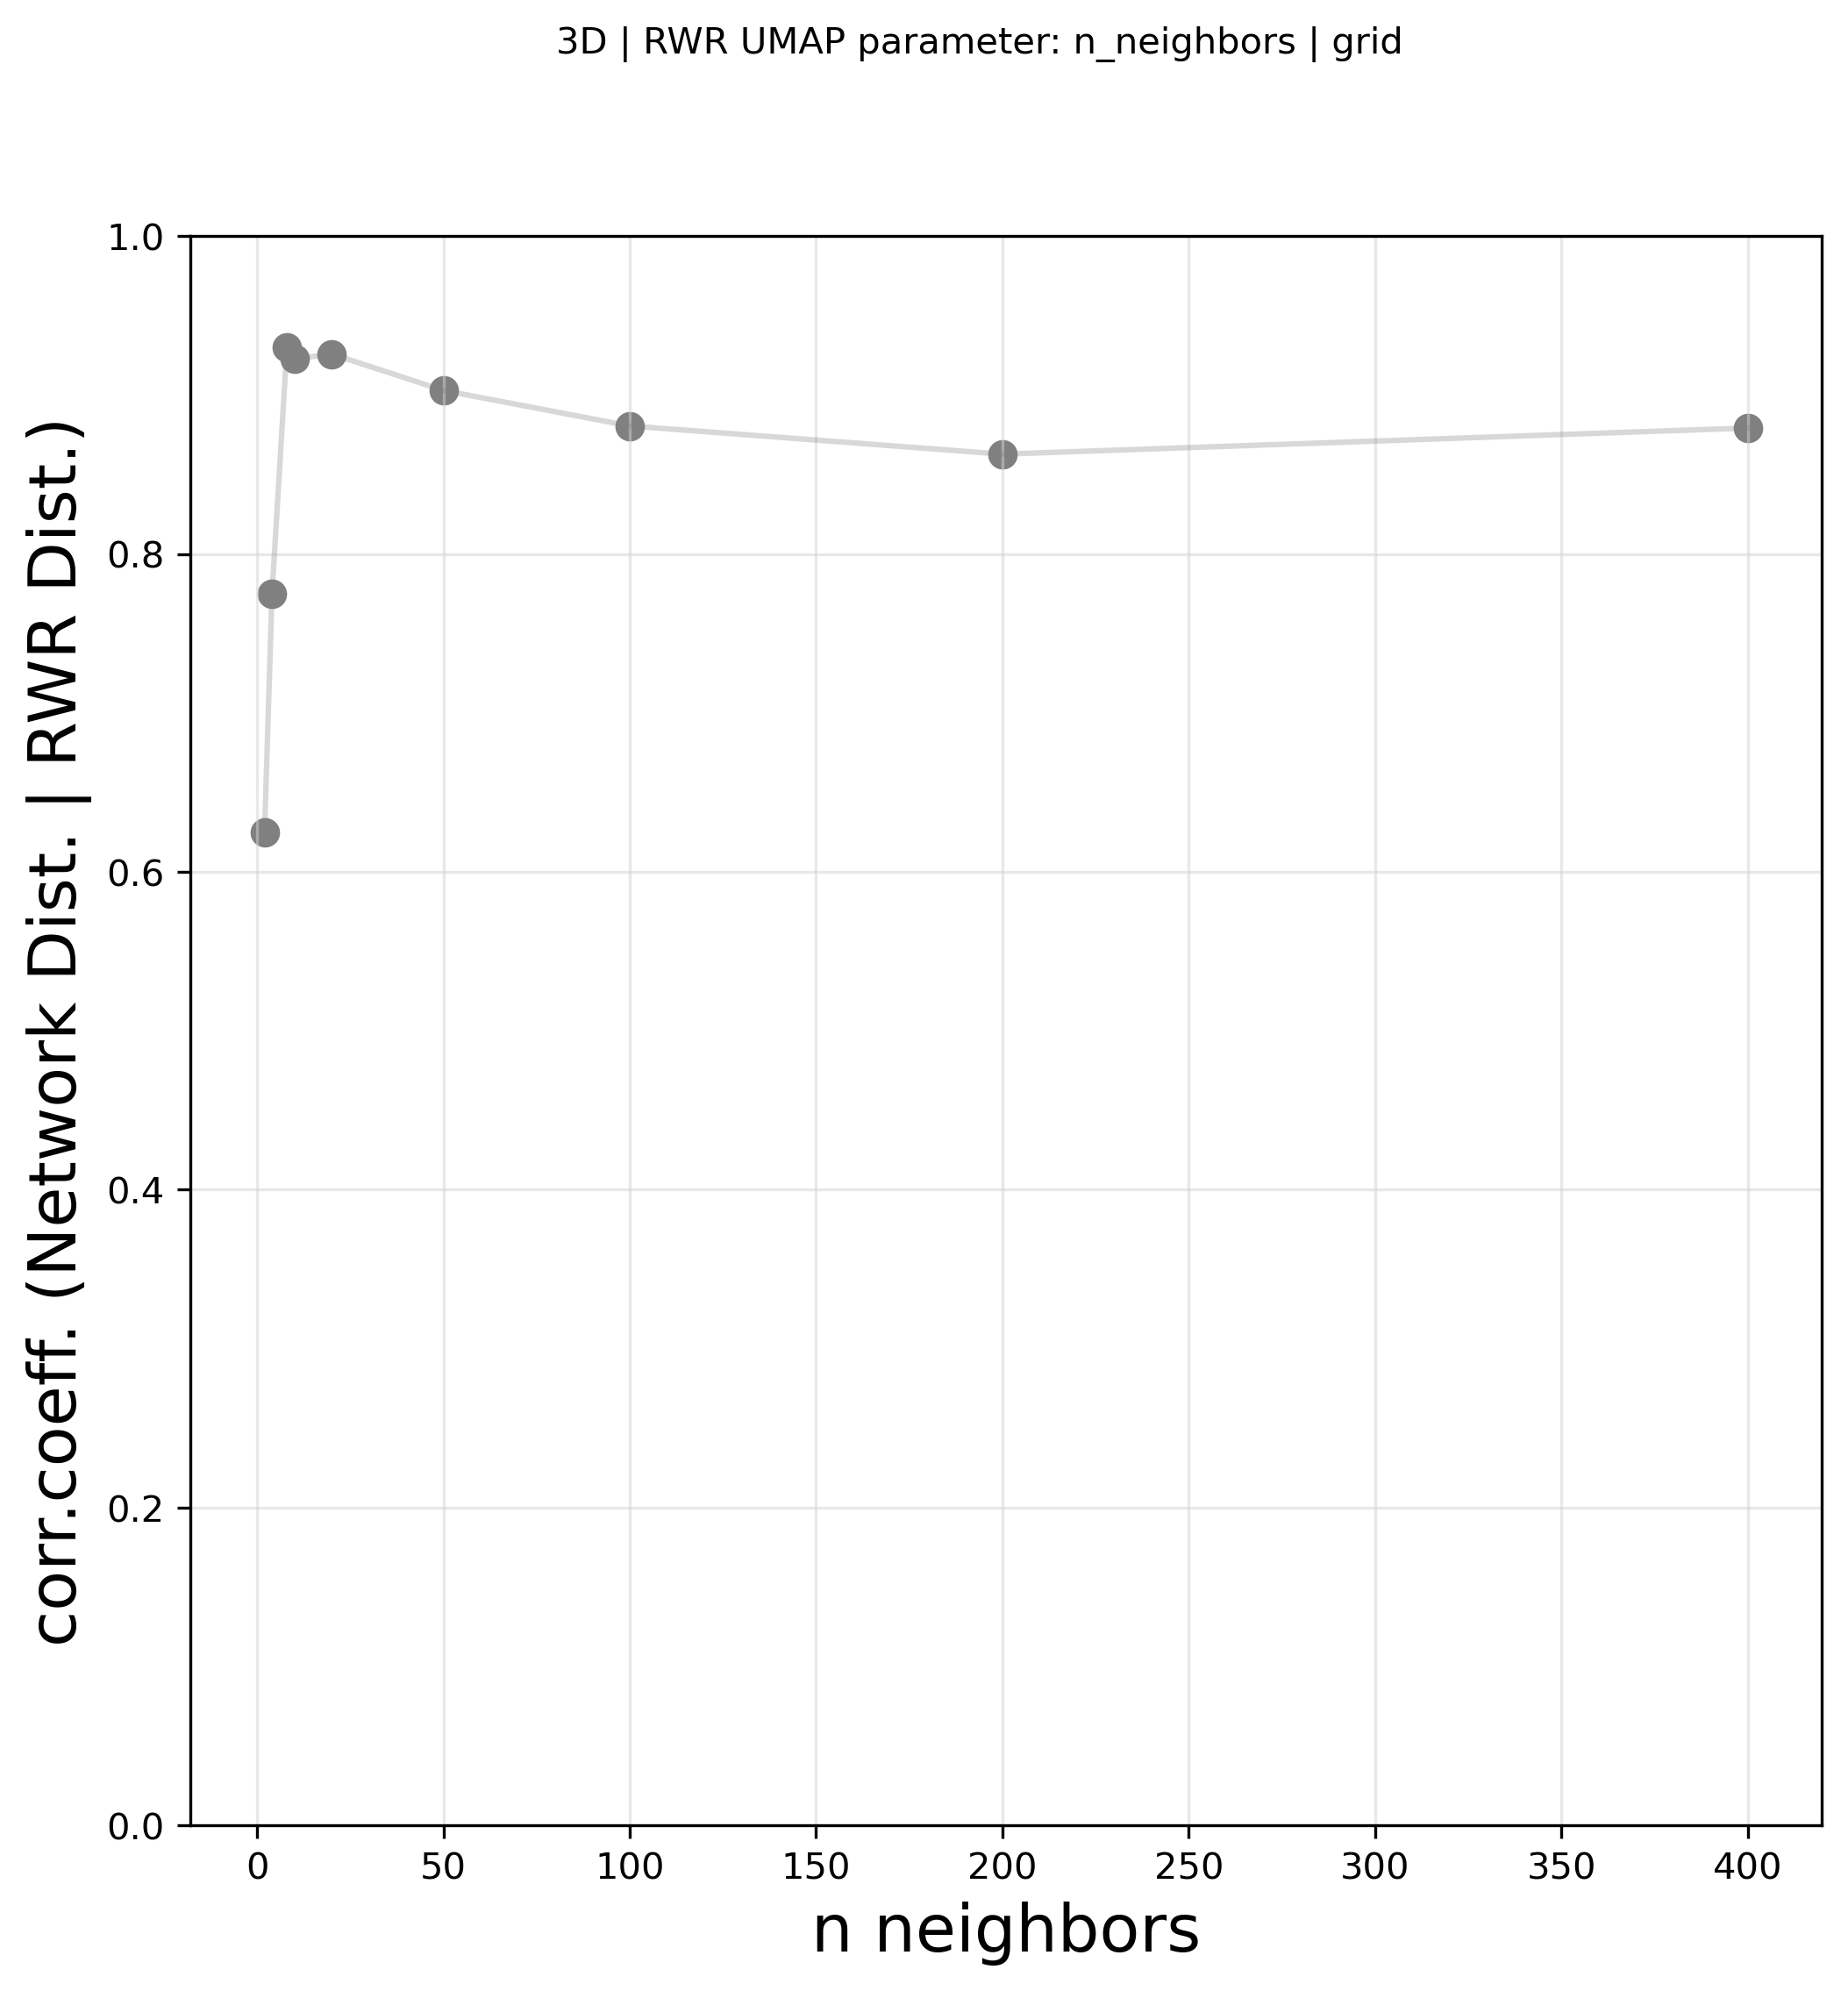

In [829]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n neighbors", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_neighs_'+feature+'_'+organism+'.png')

In [830]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 100
spread = 1.0
min_dist = 0.0
metric ='cosine'
lnr = 0
nep = None

#### ------ MIN DIST ------
+ The effective minimum distance between embedded points
+ Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points

In [831]:
# MIN DIST 

mindist_list = [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, i, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr

    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_mdist[i] = r_value_rwr

UMAP min dist: 0.001
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.01
Execution Time: 00:00:12
min: 0 sec: 12
UMAP min dist: 0.1
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.2
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.3
Execution Time: 00:00:12
min: 0 sec: 12
UMAP min dist: 0.4
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.5
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.6
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.7
Execution Time: 00:00:14
min: 0 sec: 14
UMAP min dist: 0.8
Execution Time: 00:00:13
min: 0 sec: 13
UMAP min dist: 0.9
Execution Time: 00:00:12
min: 0 sec: 12
UMAP min dist: 1
Execution Time: 00:00:14
min: 0 sec: 14


In [832]:
d_rwr_mdist

{0.001: 13,
 0.01: 12,
 0.1: 13,
 0.2: 13,
 0.3: 12,
 0.4: 13,
 0.5: 13,
 0.6: 13,
 0.7: 14,
 0.8: 13,
 0.9: 12,
 1: 14}

In [833]:
d_r_values_rwr_mdist

{0.001: 0.8805329109301595,
 0.01: 0.8805329109301595,
 0.1: 0.8805329109301595,
 0.2: 0.8805329109301595,
 0.3: 0.8805329109301595,
 0.4: 0.8805329109301595,
 0.5: 0.8805329109301595,
 0.6: 0.8805329109301595,
 0.7: 0.8805329109301595,
 0.8: 0.8805329109301595,
 0.9: 0.8805329109301595,
 1: 0.8805329109301595}

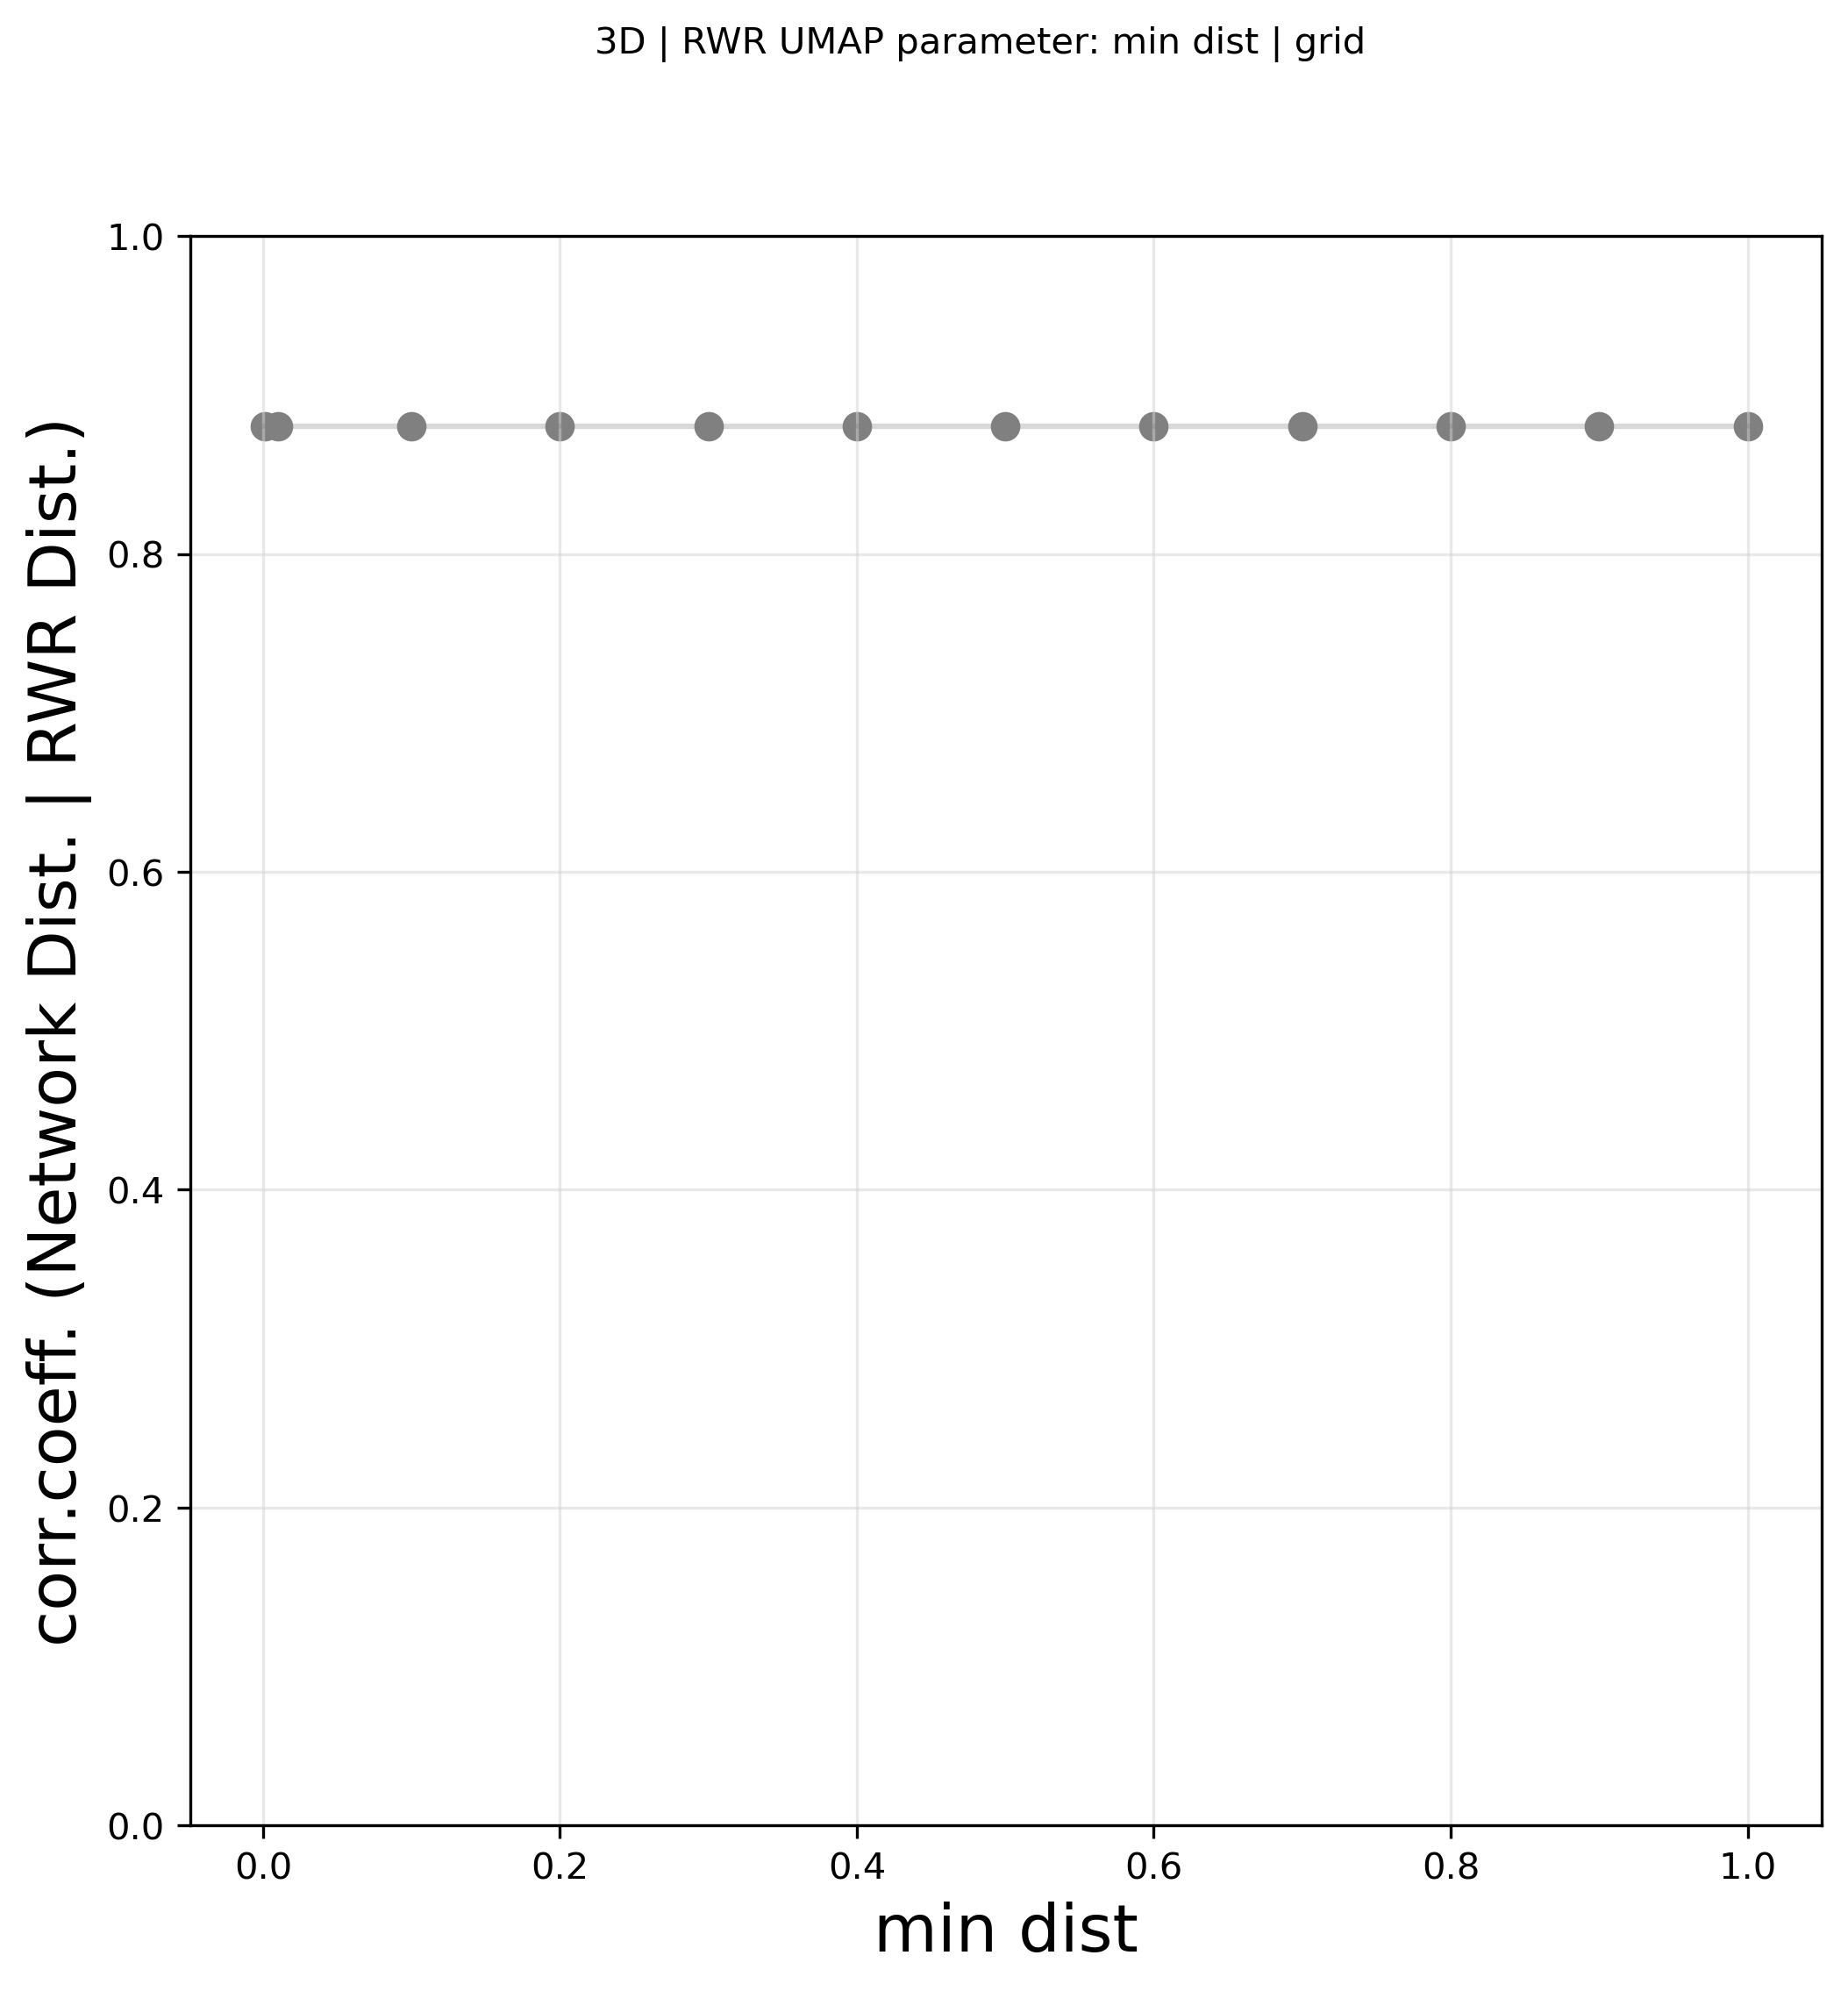

In [834]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("min dist", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: min dist | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_mindist_'+feature+'_'+organism+'.png')

In [835]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 100
spread = 1
min_dist = 0.0
metric = 'cosine'
lnr = 1
nep = None

#### ------ SPREAD ------
+ The effective scale of embedded points
+ In combination with min_dist this determines how clustered/clumped the embedded points are

In [836]:
# SPREAD

spread_list = [0.1,0.9,1,2,3,4,5,6,7,8,9,10]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, i, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_spread[i] = r_value_rwr

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning:

Covariance of the parameters could not be estimated



UMAP spread: 0.1
Execution Time: 00:00:14
min: 0 sec: 14
UMAP spread: 0.9
Execution Time: 00:00:13
min: 0 sec: 13
UMAP spread: 1
Execution Time: 00:00:14
min: 0 sec: 14
UMAP spread: 2
Execution Time: 00:00:14
min: 0 sec: 14
UMAP spread: 3
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 4
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 5
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 6
Execution Time: 00:00:14
min: 0 sec: 14


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 7
Execution Time: 00:00:13
min: 0 sec: 13


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 8
Execution Time: 00:00:12
min: 0 sec: 12


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 9
Execution Time: 00:00:12
min: 0 sec: 12


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:15
min: 0 sec: 15


In [837]:
d_rwr_spread

{0.1: 14,
 0.9: 13,
 1: 14,
 2: 14,
 3: 14,
 4: 14,
 5: 14,
 6: 14,
 7: 13,
 8: 12,
 9: 12,
 10: 15}

In [838]:
d_r_values_rwr_spread

{0.1: -0.11518951526880536,
 0.9: 0.8837833147405456,
 1: 0.8824053937243754,
 2: 0.9066073770832941,
 3: 0.9106917500934532,
 4: 0.9084175090043664,
 5: 0.9072831964367782,
 6: 0.9062599495441951,
 7: 0.9057056921331295,
 8: 0.9056180250696855,
 9: 0.9055511788225445,
 10: 0.9055958738419511}

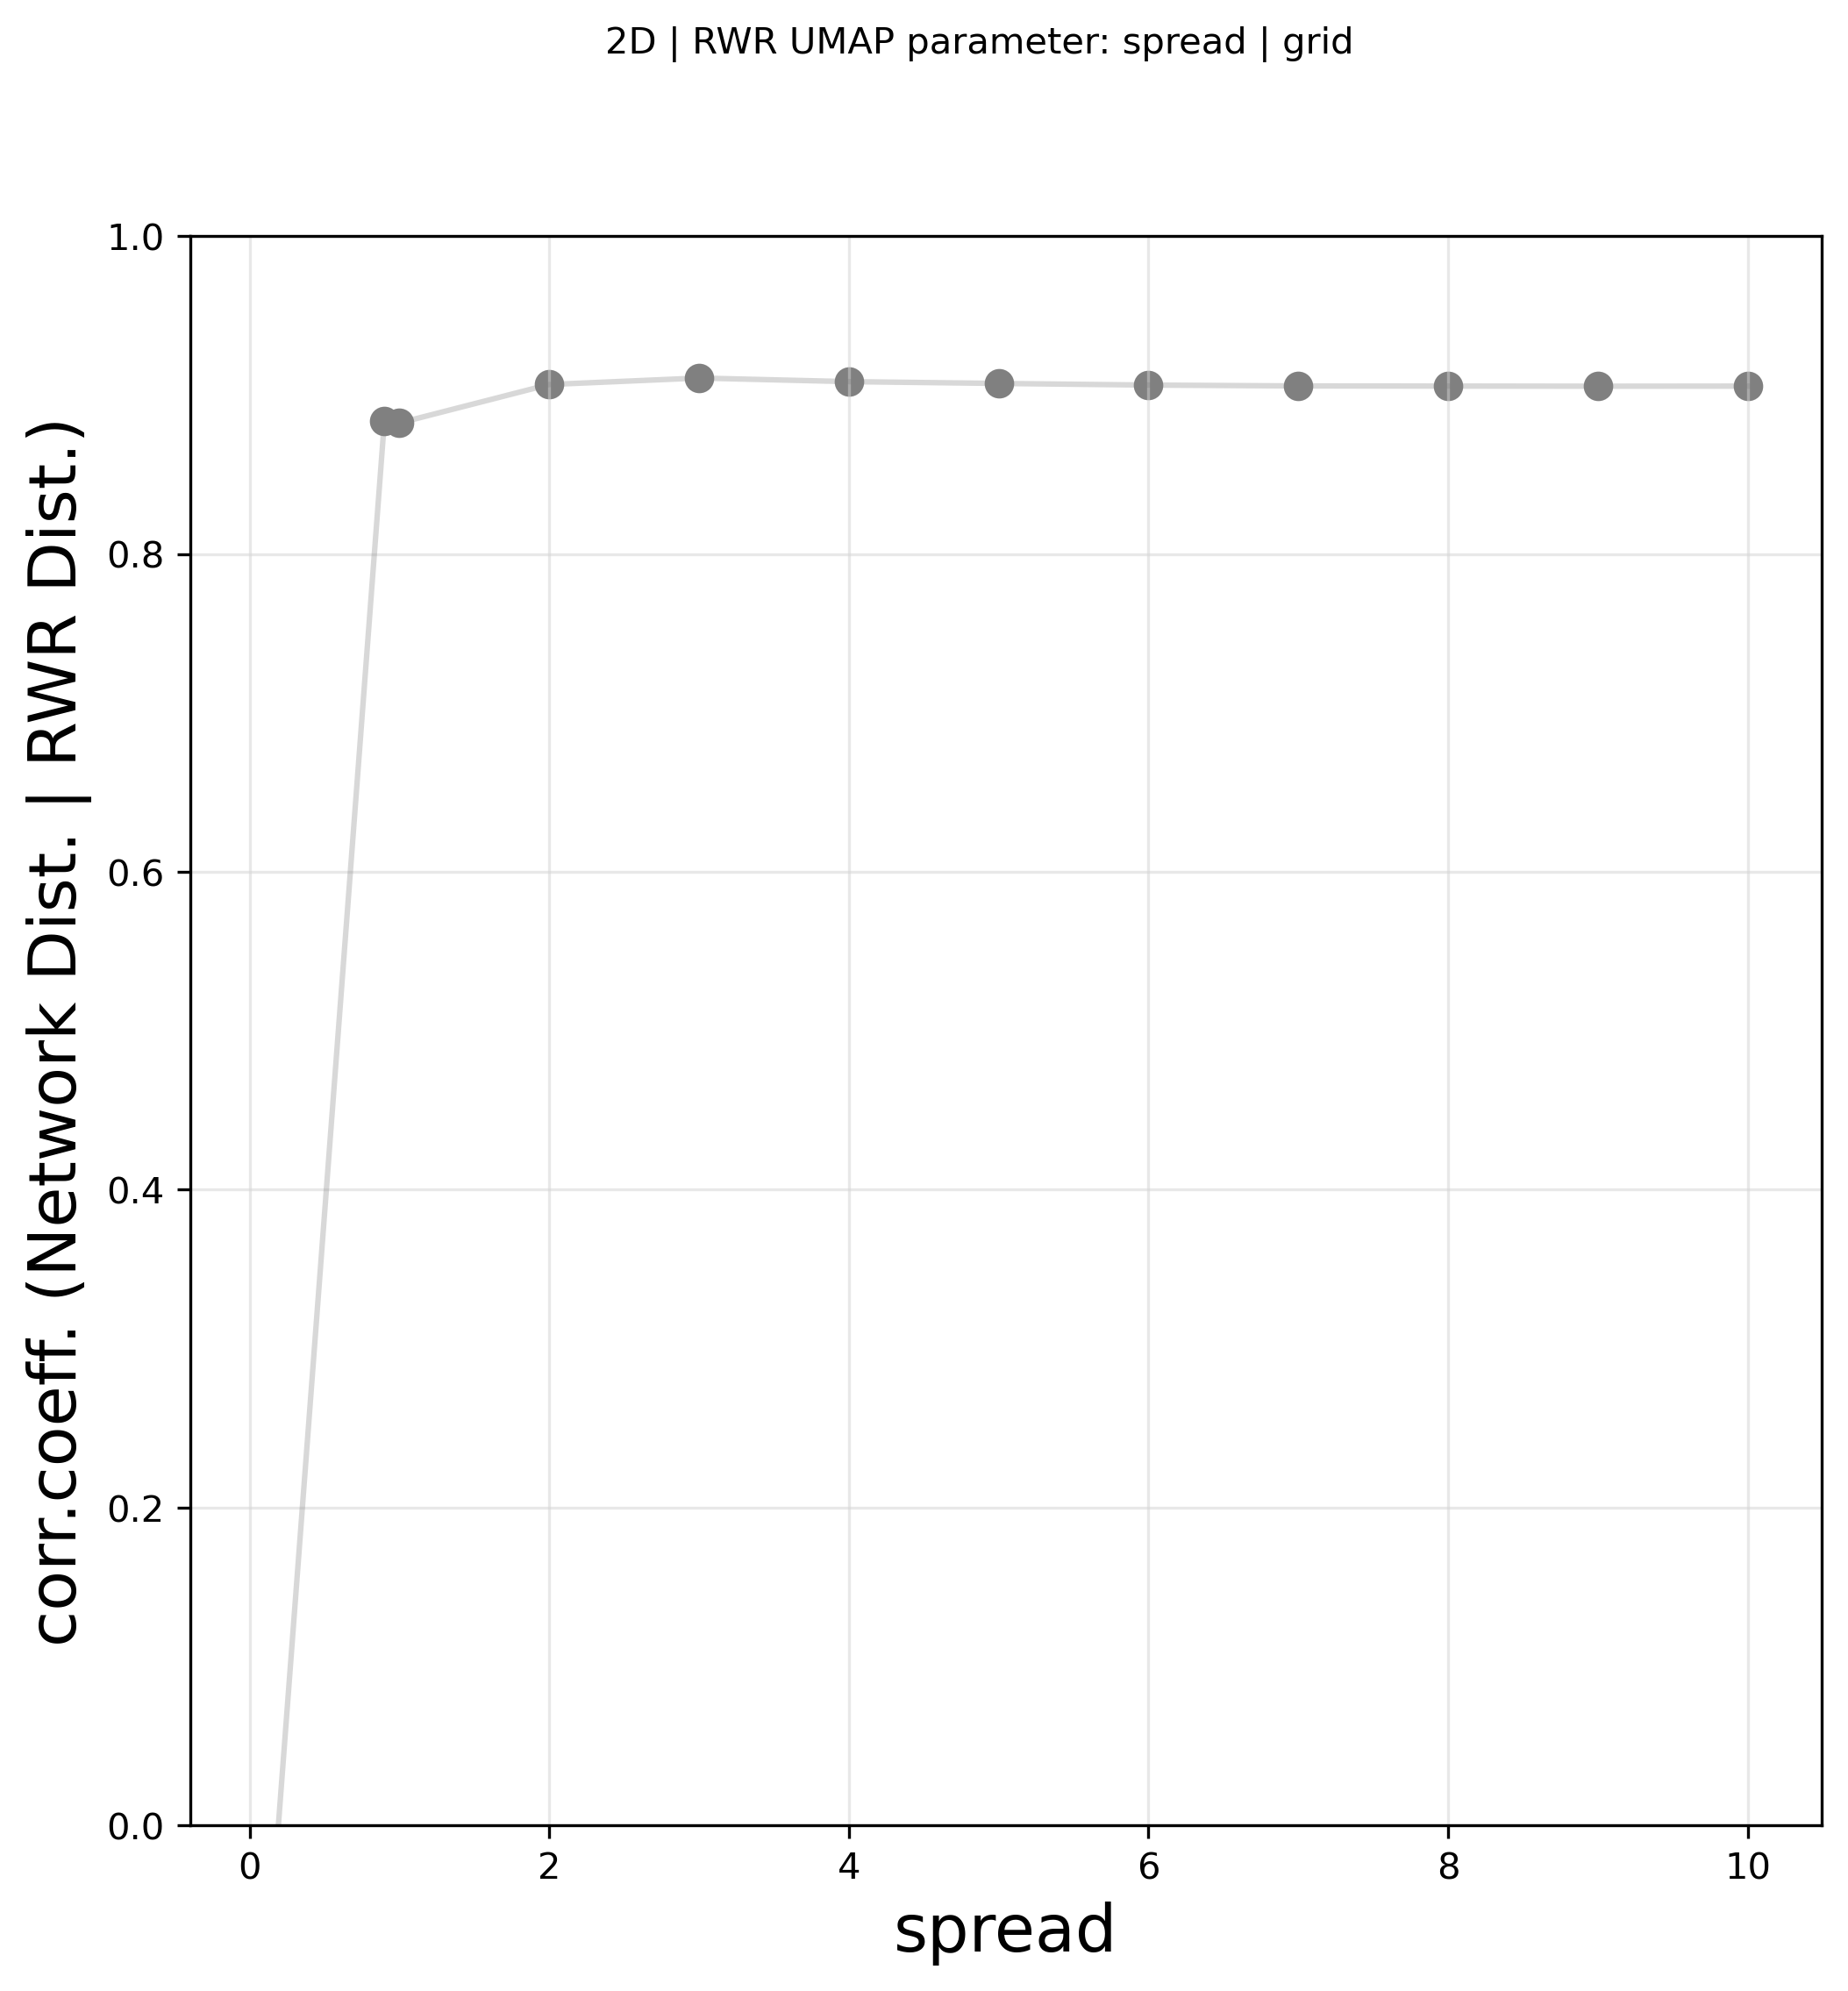

In [839]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("spread", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: spread | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_spread_'+feature+'_'+organism+'.png')

In [840]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 100
spread = 2
min_dist = 0.0
metric = 'cosine'
lnr = 1
nep = None

#### ------ NUMBER OF EPOCHS ------
+ The number of training epochs to be used in optimizing the low dimensional embedding
+ Larger values result in more accurate embeddings 
+ If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small)

In [841]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = i)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i) 
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_nep[i] = r_value_rwr

UMAP n_epoch: None
Execution Time: 00:00:14
min: 0 sec: 14
UMAP n_epoch: 100
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 200
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 300
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 400
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 500
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 600
Execution Time: 00:00:12
min: 0 sec: 12
UMAP n_epoch: 700
Execution Time: 00:00:13
min: 0 sec: 13
UMAP n_epoch: 800
Execution Time: 00:00:15
min: 0 sec: 15
UMAP n_epoch: 900
Execution Time: 00:00:15
min: 0 sec: 15
UMAP n_epoch: 1000
Execution Time: 00:00:16
min: 0 sec: 16


In [842]:
d_rwr_epochs

{None: 14,
 100: 13,
 200: 12,
 300: 13,
 400: 12,
 500: 12,
 600: 12,
 700: 13,
 800: 15,
 900: 15,
 1000: 16}

In [843]:
d_r_values_rwr_nep

{None: 0.9066073770832941,
 100: 0.878948188025193,
 200: 0.8937956508695605,
 300: 0.9004449615779604,
 400: 0.9085922368298912,
 500: 0.9066073770832941,
 600: 0.9049115132533673,
 700: 0.9102581326078866,
 800: 0.9081759971663073,
 900: 0.9057516378364027,
 1000: 0.911051425215849}

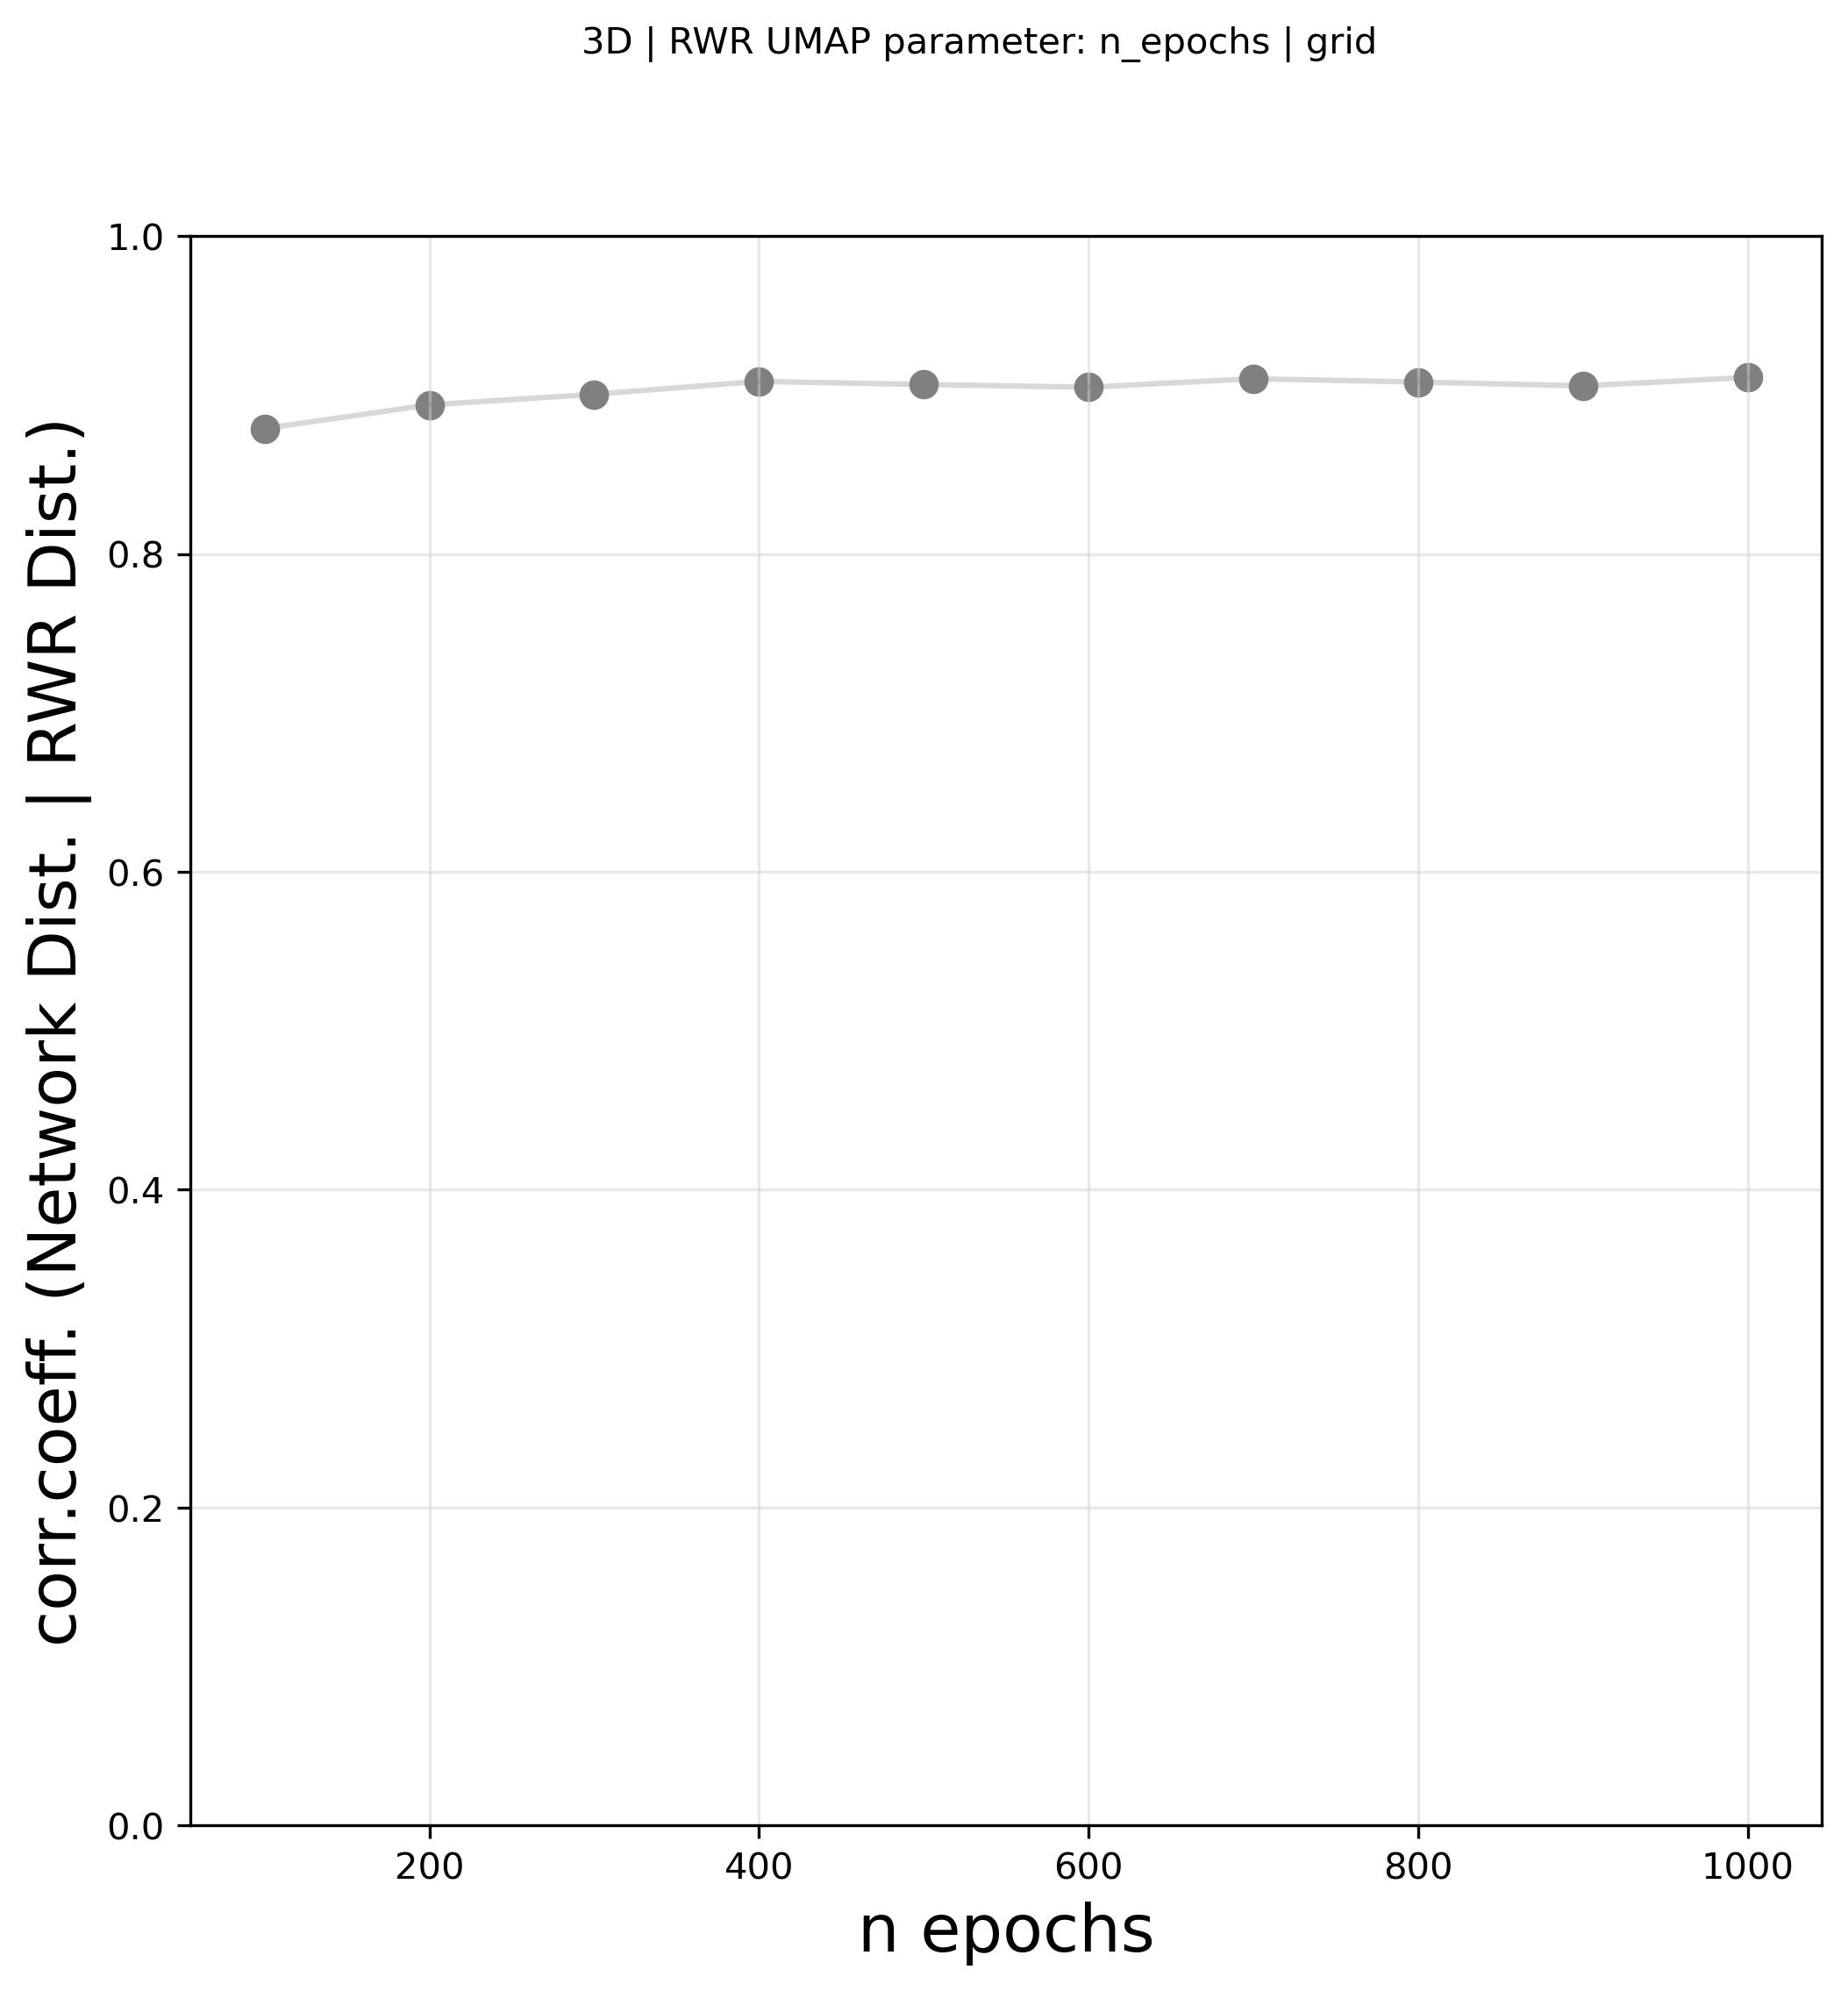

In [844]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("n epochs", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_nepochs_'+feature+'_'+organism+'.png')

In [845]:
#adjust parameters 

#-----------------------------
# INITIAL UMAP PARAMETERS:
#-----------------------------
n_neighbors = 100
spread = 2
min_dist = 0.0
metric = 'cosine'
lnr = 1
nep = None

#### ------ LEARNING RATE ------
+ The initial learning rate for the embedding optimization

In [846]:
# LEARNING RATE 

lnr_list = [0.001,0.01,0.1,1,10,100,200,300,400,500,600,700,800,900,1000]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m #.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = i, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    dist_layout3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap_rwr_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_rwr = list(dist_layout3D.values())
    x_rwr = list(dist_network3D.values())
    
    gradient_rwr, intercept_rwr, r_value_rwr, p_value_rwr, std_err_rwr = stats.linregress(x_rwr,y_rwr)
    d_r_values_rwr_lnr[i] = r_value_rwr

UMAP learning rate: 0.001
Execution Time: 00:00:13
min: 0 sec: 13
UMAP learning rate: 0.01
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 0.1
Execution Time: 00:00:11
min: 0 sec: 11
UMAP learning rate: 1
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 10
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 100
Execution Time: 00:00:14
min: 0 sec: 14
UMAP learning rate: 200
Execution Time: 00:00:13
min: 0 sec: 13
UMAP learning rate: 300
Execution Time: 00:00:13
min: 0 sec: 13
UMAP learning rate: 400
Execution Time: 00:00:14
min: 0 sec: 14
UMAP learning rate: 500
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 600
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 700
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 800
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 900
Execution Time: 00:00:12
min: 0 sec: 12
UMAP learning rate: 1000
Execution Time: 00:00:12
min: 0 sec: 12


In [847]:
d_rwr_lnr

{0.001: 13,
 0.01: 12,
 0.1: 11,
 1: 12,
 10: 12,
 100: 14,
 200: 13,
 300: 13,
 400: 14,
 500: 12,
 600: 12,
 700: 12,
 800: 12,
 900: 12,
 1000: 12}

In [848]:
d_r_values_rwr_lnr

{0.001: 0.8875396950757851,
 0.01: 0.8945584362299056,
 0.1: 0.9046334287113353,
 1: 0.9066073770832941,
 10: 0.8823798340596056,
 100: 0.751375514687162,
 200: 0.732492342344858,
 300: 0.06648189992050382,
 400: -0.006964367687012899,
 500: 0.01059827413819025,
 600: 0.0018266134826702008,
 700: 0.0004073158386916098,
 800: 0.01174516796159289,
 900: 0.0026362832155512324,
 1000: -0.0019115950385931342}

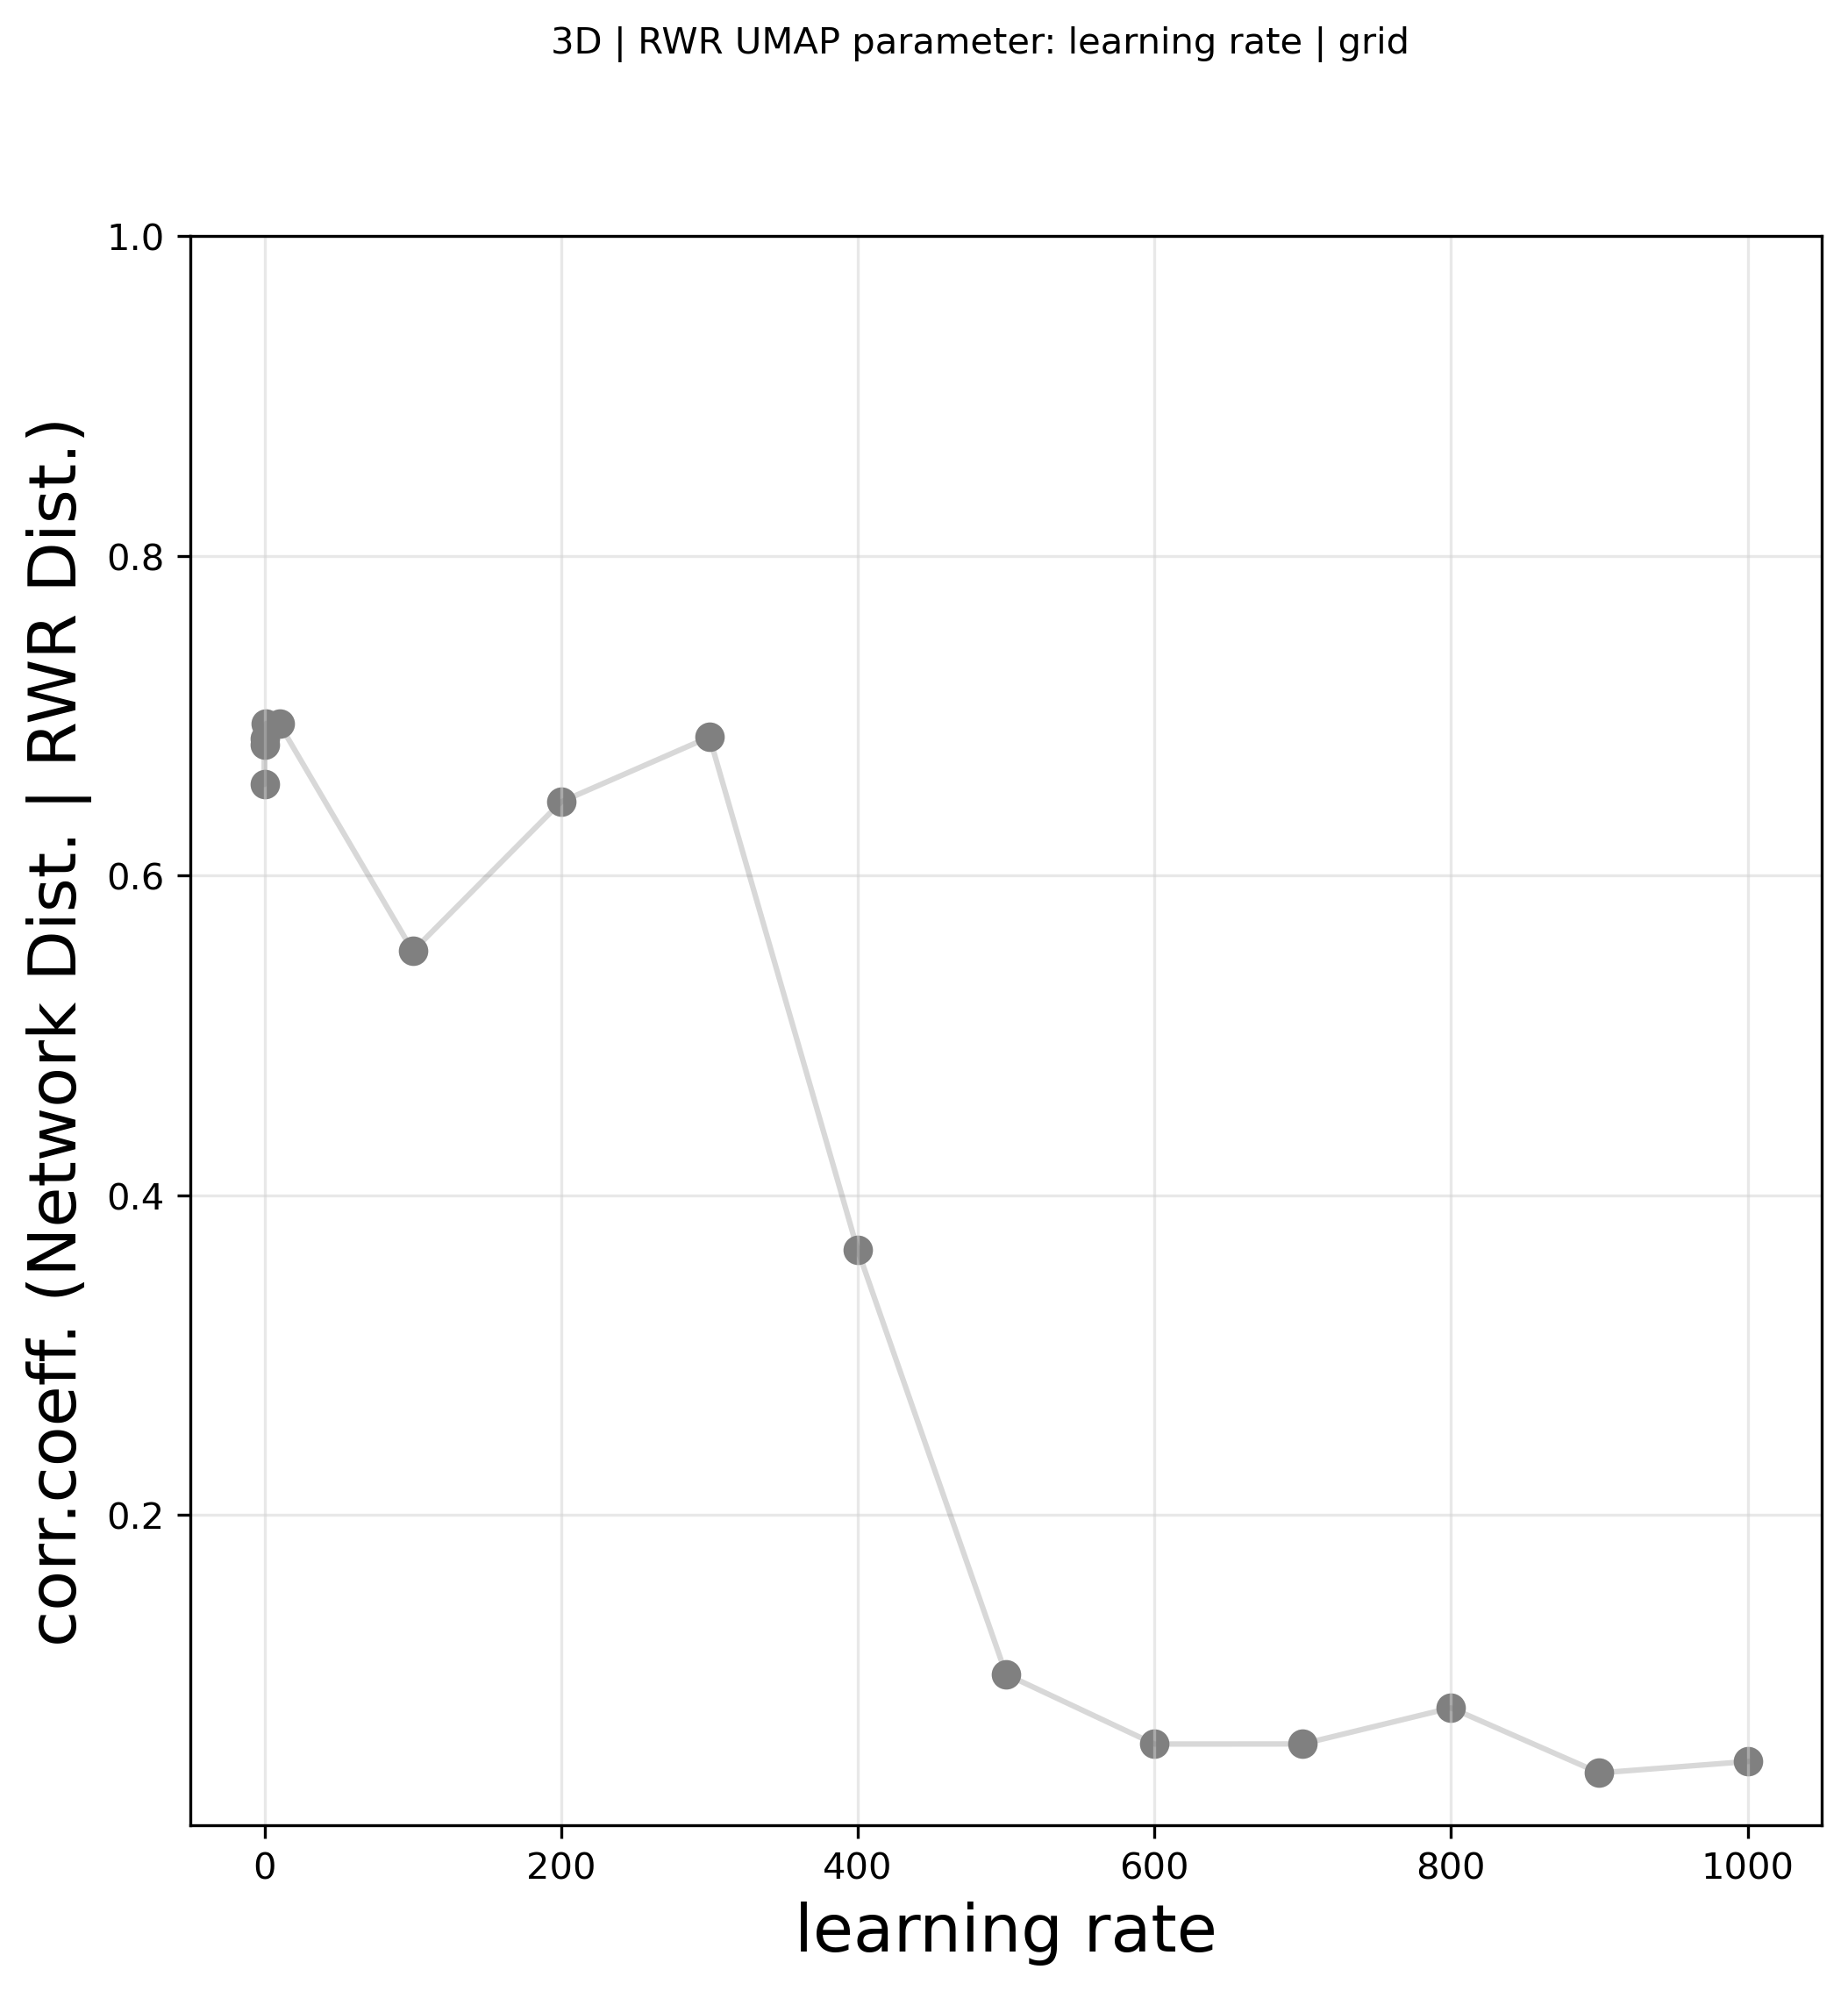

In [980]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("learning rate", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=labelsize)

plt.plot(x,y, '-', c = 'grey', alpha = 0.3)
plt.scatter(x,y, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)
plt.ylim(#ymin=0,
         ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_learnrate_'+feature+'_'+organism+'.png')